# Social Graphs and Interactions Project - Group 35

## Data Preprocessing & Network Setup

In [567]:
# Installing necessary libraries 
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install networkx
# !pip install powerlaw
# !pip install graphistry
# !pip install cpi
# !pip install nltk
# !pip install scipy

In [568]:
# Importing necessary libraries
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import networkx as nx
import powerlaw
import seaborn as sns
import graphistry
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from scipy import stats
import cpi
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import chain
from community import community_louvain
import math

nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\musti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\musti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load data & initialize graph nodes

The following code block loads the Boxofficemojo dataset, removes movies where there is no worldwide box office data, convert runtime to integers, converts release date to "xx-xx-xxxx" format and initializes the graph nodes  

In [569]:
movies = pd.read_csv(r'data\Kaggle\Mojo_budget_update.csv\Mojo_budget_update.csv')
# remove a column mpaa
movies = movies.drop(columns=['mpaa'])
# remove rows with nan in worldwide and in budget
movies = movies.dropna(subset=["worldwide"])
# movies = movies.dropna(subset=["budget"])
# fill nan with unknown
movies = movies.fillna("UNKNOWN",)

#Make a graph
movie_graph = nx.Graph()
movie_graph.add_nodes_from(movies['title'])

# reformat the date
def getDate(year,date):
    dict_months = {'January':"1", 'February':"2", 'March':"3", 'April':"4", 'May':"5", 'June':"6", 'July':"7", 'August':"8", 'September':"9", 'October':"10", 'November':"11", 'December':"12"}
    try:
        date = date.split()
    except:
        date = ['January','1']
    year = str(year)
    date = str(date[1]) + '-' + dict_months[date[0]] + '-' + year
    return date

# reformat the run time
def getRunTime(run_time):
    try:
        run_time = run_time.split()
        run_time = int(run_time[0]) * 60 + int(run_time[2])
    except:
        run_time = "UNKNOWN"
    return run_time

# add attributes to the nodes
for node in movie_graph.nodes:
    row = movies.loc[movies['title'] == node]
    movie_id, _,release_year,_,release_date, run_time, distributor, director, writer, producer, composer, cinematographer, \
    main_actor_1, main_actor_2, main_actor_3, main_actor_4, budget, domestic, international, worldwide, \
    genre_1, genre_2, genre_3, genre_4, link = row.iloc[0, :].values

    release_date = getDate(release_year, release_date)
    run_time = getRunTime(run_time)
    actors = [main_actor_1, main_actor_2, main_actor_3, main_actor_4]
    genres = [genre_1, genre_2, genre_3, genre_4]
    
    movie_graph.nodes[node]['movie_id'] = movie_id
    movie_graph.nodes[node]['release_year'] = release_year
    movie_graph.nodes[node]['release_date'] = release_date
    movie_graph.nodes[node]['run_time'] = run_time
    movie_graph.nodes[node]['distributor'] = distributor
    movie_graph.nodes[node]['director'] = director
    movie_graph.nodes[node]['writer'] = writer
    movie_graph.nodes[node]['producer'] = producer
    movie_graph.nodes[node]['composer'] = composer
    movie_graph.nodes[node]['cinematographer'] = cinematographer
    movie_graph.nodes[node]['actors'] = actors
    movie_graph.nodes[node]['budget'] = budget
    movie_graph.nodes[node]['domestic'] = domestic
    movie_graph.nodes[node]['international'] = international
    movie_graph.nodes[node]['worldwide'] = worldwide
    movie_graph.nodes[node]['genres'] = genres
    movie_graph.nodes[node]['link'] = link


In [570]:
# Print information about the movie network

print("Number of nodes", len(movie_graph.nodes)) 
print("Number of unique distributor", len(movies["distributor"].unique()))
# print("percentage of movies per distributor" , movies["distributor"].value_counts())
print(f"Budget Stats \n mean is {round(movies["budget"].mean())}, midian is {movies["budget"].median()}, standard deviation budget is { round(movies["budget"].std())}")
print(f"worldwide Stats \n mean is {round(movies["worldwide"].mean())}, midian is {movies['worldwide'].median()}, standard deviation worldwide is { round(movies['worldwide'].std())}")
print("Number of unique genres", len(movies["genre_1"].unique()))
print("Number of unique actors", len((movies["main_actor_1"]+movies["main_actor_2"]+movies["main_actor_3"]+movies["main_actor_4"]).unique()))
print(f"Number of unique directors {len(movies['director'].unique())} writers {len(movies['writer'].unique())} and producers {len(movies['producer'].unique())} and composers {len(movies['composer'].unique())} and cinematographers {len(movies['cinematographer'].unique())}")
print(f"Earnings Stats \n mean is {round(movies['worldwide'].mean())-round(movies['budget'].mean())}, midian is {movies['worldwide'].median()-movies['budget'].median()}")
print("biggest Winner is ", movies.loc[(movies['worldwide']-movies['budget']).idxmax()]['title'])
print("biggest Loser is ", movies.loc[(movies['worldwide']-movies['budget']).idxmin()]['title'])

Number of nodes 3208
Number of unique distributor 197
Budget Stats 
 mean is 46308759, midian is 30000000.0, standard deviation budget is 47097816
worldwide Stats 
 mean is 139312154, midian is 62251587.5, standard deviation worldwide is 216210703
Number of unique genres 15
Number of unique actors 3212
Number of unique directors 1520 writers 2103 and producers 1539 and composers 792 and cinematographers 854
Earnings Stats 
 mean is 93003395, midian is 32251587.5
biggest Winner is  Avatar
biggest Loser is  Mars Needs Moms


In [571]:
movies[movies['title'] == 'The Matrix']

movie_id       title  year  \
464  tt0133093  The Matrix  1999   

                                                trivia release_date  \
464  A computer hacker learns from mysterious rebel...     March 31   

        run_time   distributor        director           writer     producer  \
464  2 hr 16 min  Warner Bros.  Lana Wachowski  Lilly Wachowski  Joel Silver   

     ...  main_actor_4      budget     domestic international    worldwide  \
464  ...  Hugo Weaving  63000000.0  171479930.0   293863857.0  465343787.0   

    genre_1  genre_2  genre_3  genre_4  \
464  Action   Sci-Fi  UNKNOWN  UNKNOWN   

                                                  html  
464  https://www.boxofficemojo.com/title/tt0133093/...  

[1 rows x 25 columns]

The following code block does:
* Reads the Rotten Tomatoes reviews dataset
* keeps the movie id, reviewid, and review text
* drop rows that holds no review text
* Reads the Rotten Tomatoes movies dataset (where it  holds information about the movies)
* Joins the 2 data sets into a `merged_reviews` data sets that now holds id, reviewId, reviewText and movie title

In [572]:
reviews = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movie_reviews.csv')
reviews_head = reviews.head()
reviews=reviews[["id","reviewId","reviewText"]]
reviews = reviews.dropna(subset=["reviewText"])
RT_movies = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movies.csv')
RT_movies=RT_movies[["id","title","tomatoMeter"]]
merged_reviews = pd.merge(RT_movies, reviews, on='id')
merged_reviews = pd.merge(merged_reviews, movies[['title']], left_on='title', right_on='title')

In [573]:
print("number of movies with reviews", len(merged_reviews['title'].unique()))
print("number of reviews", len(merged_reviews['reviewId'].unique()))
print("number of reviews per movie", merged_reviews['title'].value_counts(ascending=False))
print(f"mean number of reviews per movie {merged_reviews['title'].value_counts().mean()} median {merged_reviews['title'].value_counts().median()}")
print("number of movies with more than 50 reviews", len(merged_reviews['title'].value_counts()[merged_reviews['title'].value_counts()>50]))
print(f"The mean length of reviews is {merged_reviews['reviewText'].apply(len).mean()} and the median is {merged_reviews['reviewText'].apply(len).median()}")
print(f"The mean number of words in reviews is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).mean()} and the median is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).median()}")

number of movies with reviews 2932
number of reviews 413562
number of reviews per movie title
Parasite                1921
Beauty and the Beast    1168
The Lion King           1122
Godzilla                1084
Little Women            1038
                        ... 
The Lorax                  1
Royal Kill                 1
A Long Way Off             1
Beat the Drum              1
Alone Yet Not Alone        1
Name: count, Length: 2932, dtype: int64
mean number of reviews per movie 146.55388813096863 median 130.0
number of movies with more than 50 reviews 2448
The mean length of reviews is 127.99440301980935 and the median is 127.0
The mean number of words in reviews is 21.466581024724455 and the median is 21.0


### Add the reviews of the movies in nodes

In [574]:
dicReviews = {}
for index, row in merged_reviews.iterrows():
    if row['title'] in movie_graph.nodes:
        if row['title'] not in dicReviews:
            dicReviews[row['title']] = []
        dicReviews[row['title']].append(row['reviewText'])
print("Number of movies with reviews", len(dicReviews))
print("total number of reviews", len([j for i in dicReviews.values() for j in i]))

for node in movie_graph.nodes:
    if node in dicReviews:
        movie_graph.nodes[node]['reviews'] = dicReviews[node]
        movie_graph.nodes[node]['tomatoMeter'] =merged_reviews.loc[merged_reviews['title'] == node]['tomatoMeter'].values[0] 

Number of movies with reviews 2932
total number of reviews 429696


In [575]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 3208


### Remove movies with no reviews

In [576]:
nodes_to_remove = []

# Find nodes without the "reviews" attributes
for node in movie_graph.nodes:
    if movie_graph.nodes[node].get("reviews") is None:
        nodes_to_remove.append(node)

# Remove those nodes from the graph
movie_graph.remove_nodes_from(nodes_to_remove)

In [577]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 2932


### Adjust the monetary values for inflation

In [578]:
##  Values to adjust : budget, domestic, international, worldwide 
for node in movie_graph.nodes:
    movie_graph.nodes[node]['budget'] = cpi.inflate(int(movie_graph.nodes[node]['budget']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['domestic'] != "UNKNOWN":
        movie_graph.nodes[node]['domestic'] = cpi.inflate(int(movie_graph.nodes[node]['domestic']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['international'] != "UNKNOWN":
        movie_graph.nodes[node]['international'] = cpi.inflate(int(movie_graph.nodes[node]['international']), movie_graph.nodes[node]['release_year'])
    movie_graph.nodes[node]['profit'] = movie_graph.nodes[node]['worldwide'] - movie_graph.nodes[node]['budget']

### Calculate the sentiment of nodes

In [579]:
# Create an instance of the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# get sentiment for each review in each node
for node in movie_graph.nodes:
    reviews = movie_graph.nodes[node]['reviews']

    sentiments_per_review = [analyzer.polarity_scores(review) for review in reviews]
    
    # movie's sentiment based on all reviews (mean compound score)          
    compound_sentiments = [sentiment_scores["compound"] for sentiment_scores in sentiments_per_review]
    movie_sentiment = np.mean(compound_sentiments) if compound_sentiments else 0.0
    
    # Assign the aggregated sentiment to the node
    movie_graph.nodes[node]['mean_compound_sentiment'] = movie_sentiment
    movie_graph.nodes[node]['sentiments_per_review'] = sentiments_per_review

In [580]:
for node in list(movie_graph.nodes)[:5]:
    print(f"- Movie : {node}")
    print(f"- Mean Compound Sentiment : {movie_graph.nodes[node]["mean_compound_sentiment"]}")
    print(f"- Rotten Tomatoes score : {movie_graph.nodes[node]["tomatoMeter"]}", "\n")


- Movie : Back to the Future Part III
- Mean Compound Sentiment : 0.4589757575757576
- Rotten Tomatoes score : 80.0 

- Movie : The Bonfire of the Vanities
- Mean Compound Sentiment : -0.07092222222222222
- Rotten Tomatoes score : 15.0 

- Movie : Dick Tracy
- Mean Compound Sentiment : 0.1416142857142857
- Rotten Tomatoes score : nan 

- Movie : Die Hard 2
- Mean Compound Sentiment : 0.10247884615384614
- Rotten Tomatoes score : 70.0 

- Movie : Flight of the Intruder
- Mean Compound Sentiment : 0.02735
- Rotten Tomatoes score : 25.0 



#### Bayesian Adjustment of movie sentiments

In this analysis, we apply **Bayesian adjustment** to refine the sentiment of each movie based on its review count and the global sentiment of all movies in the network.

The basic idea is to adjust each movie's sentiment by **shrinking** it toward the **global sentiment (Prior)**, especially for movies with fewer reviews, which may have more uncertainty in their sentiment values. This way, movies with fewer reviews are "regularized" and their sentiment is adjusted closer to the overall trend of the movie network.

The formula for Bayesian adjustment is:

$$
\text{Adjusted Sentiment}_i = \frac{(n_i \cdot \text{mean\_sentiment}_i) + (m \cdot \text{Global Sentiment})}{n_i + m}
$$

Where:
- \( $ n_i $ \) is the number of reviews for movie \( $ i $ \),
- \( $ \text{mean\_sentiment}\_i $ \) is the mean sentiment of movie \( $ i $ \),
- \( $ m $ \) is a tuning parameter that controls the influence of the **Global Sentiment** (Prior),
- \( $ \text{Global Sentiment} $ \) is the average sentiment of all movies in the network.

This adjustment helps to reduce the influence of movies with fewer reviews and ensures that the global sentiment remains consistent even when a movie has only a few data points.


##### PRIOR (Global sentiment) based on the unadjusted sentiments


In [581]:
# Calculate the Global Sentiment (Prior) as the mean of the mean_compound_sentiment values
def calculate_global_sentiment(G, adjusted=False):
    total_sentiment = 0
    num_movies = len(G.nodes)
    
    sentiment_type = "adjusted_sentiment" if adjusted else "mean_compound_sentiment" 
    
    for node in G.nodes:
        total_sentiment += G.nodes[node][sentiment_type]
    
    return total_sentiment / num_movies

# Calculate the initial Global Sentiment (Prior)
global_sentiment = calculate_global_sentiment(movie_graph)
print(global_sentiment)

0.17876725900853307


##### Adjustment of the sentiments

In [582]:
# Apply Bayesian Adjustment for each movie using the Prior
def apply_bayesian_adjustment(G, global_sentiment, m=5):
    for node in G.nodes:
        num_reviews = len(G.nodes[node]["reviews"])  
        mean_sentiment = G.nodes[node]["mean_compound_sentiment"]
        
        # Apply Bayesian adjustment
        adjusted_sentiment = (num_reviews * mean_sentiment + m * global_sentiment) / (num_reviews + m)
        
        # Update the node with the adjusted sentiment
        G.nodes[node]["adjusted_sentiment"] = adjusted_sentiment


apply_bayesian_adjustment(movie_graph, global_sentiment)

##### PRIOR (Global sentiment) after the adjustment of sentiments

In [583]:
# Recalculate the Global Sentiment after adjustment
adjusted_global_sentiment = calculate_global_sentiment(movie_graph, adjusted=True)

##### BAYESIAN ADJUSTMENT OVERVIEW

In [584]:
print("GLOBAL SENTIMENT (PRIOR):")
print(f"Initial Sentiment: {global_sentiment:.5f}")
print(f"Sentiment after Bayesian adjustment: {adjusted_global_sentiment:.5f}\n\n")

print("MOVIE SENTIMENTS ADJUSTMENTS EXAMPLES:\n")
# Print the adjusted sentiments for each movie
for node in list(movie_graph.nodes)[:5]:
    print(f"Movie: {node}")
    print(f"Initial Sentiment: {movie_graph.nodes[node]['mean_compound_sentiment']:.5f}")
    print(f"Sentiment after Bayesian adjustment: {movie_graph.nodes[node]['adjusted_sentiment']:.5f}\n")

GLOBAL SENTIMENT (PRIOR):
Initial Sentiment: 0.17877
Sentiment after Bayesian adjustment: 0.18035


MOVIE SENTIMENTS ADJUSTMENTS EXAMPLES:

Movie: Back to the Future Part III
Initial Sentiment: 0.45898
Sentiment after Bayesian adjustment: 0.42211

Movie: The Bonfire of the Vanities
Initial Sentiment: -0.07092
Sentiment after Bayesian adjustment: -0.04047

Movie: Dick Tracy
Initial Sentiment: 0.14161
Sentiment after Bayesian adjustment: 0.14557

Movie: Die Hard 2
Initial Sentiment: 0.10248
Sentiment after Bayesian adjustment: 0.10917

Movie: Flight of the Intruder
Initial Sentiment: 0.02735
Sentiment after Bayesian adjustment: 0.11147



### Add edges to the graph 
Two movie nodes have an edge between them if there is at least one common actor between the two movies 

In [585]:
# list of movies for each actor
actor_to_movies = defaultdict(set)

for movie in movie_graph.nodes:
    actors = movie_graph.nodes[movie].get('actors', [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)


In [586]:
# Add edges between movies that share an actor
for actor, movies in actor_to_movies.items():
    movie_list = list(movies)
    for i in range(len(movie_list)):
        for j in range(i + 1, len(movie_list)):
            movie_graph.add_edge(movie_list[i], movie_list[j], actor=actor)

In [587]:
print(f"Number of nodes: {movie_graph.number_of_nodes()}")
print(f"Number of edges: {movie_graph.number_of_edges()}")

Number of nodes: 2932
Number of edges: 37774


### Delete isolated nodes

In [588]:
# Remove isolated nodes
isolated_nodes = [node for node, degree in dict(movie_graph.degree()).items() if degree == 0]

graph_no_isolated = movie_graph.copy()
graph_no_isolated.remove_nodes_from(isolated_nodes)

### Extract the largest connected component

In [589]:
# Extract the largest connected component
graph = graph_no_isolated
largest_component = max(nx.connected_components(graph), key=len)
graph_largest = graph.subgraph(largest_component).copy()

In [590]:
print(f"Initial network number of nodes: {movie_graph.number_of_nodes()}")
print(f"Initial network edges: {movie_graph.number_of_edges()}")

print(f"\nNetwork number of nodes after excluding isolated nodes: {graph.number_of_nodes()}")
print(f"Network number of edges after excluding isolated nodes: {graph.number_of_edges()}")

print(f"\nNumber of nodes in largest_component: {graph_largest.number_of_nodes()}")
print(f"Number of edges in largest_component: {graph_largest.number_of_edges()}")

Initial network number of nodes: 2932
Initial network edges: 37774

Network number of nodes after excluding isolated nodes: 2799
Network number of edges after excluding isolated nodes: 37774

Number of nodes in largest_component: 2777
Number of edges in largest_component: 37758


# Network analysis

### Degree distribution

In [617]:
# Get degree distribution
degree_sequence = sorted([d for n, d in graph_largest.degree()], reverse=True)  # Sorted list of degrees
degree_count = np.bincount(degree_sequence)  # Count occurrences of each degree
degrees = np.arange(len(degree_count)) 

# Check for hubs in the network
max_degree = max(degree_sequence)
average_degree = np.mean(degree_sequence)
print("Maximum degree:", max_degree)
print("Average degree:", average_degree)

Maximum degree: 91
Average degree: 27.193374144760533


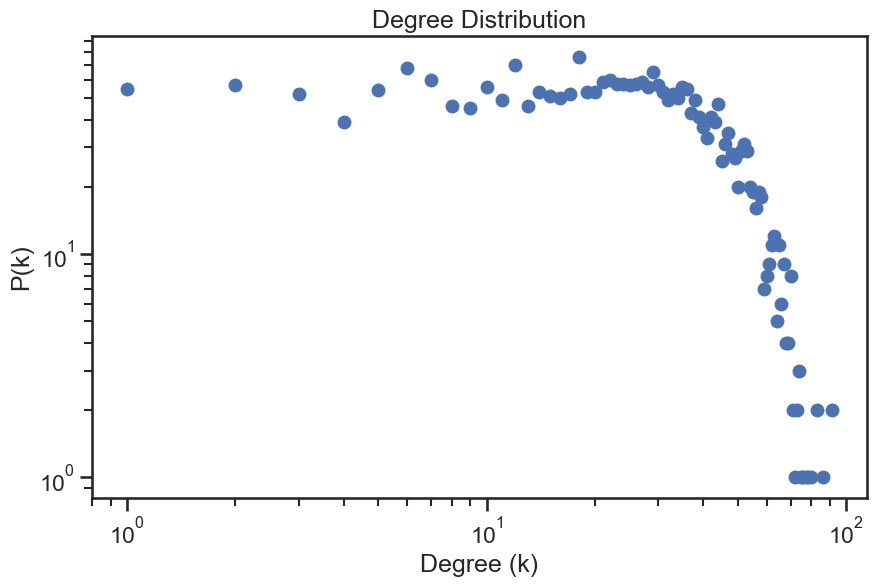

In [618]:
# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.loglog(degrees[degrees > 0], degree_count[degrees > 0], 'bo')  # Exclude zero degree entries
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution")
plt.show()

In [619]:
degree_sequence_sorted = sorted(degree_sequence, reverse=True)
px = [(degree_sequence_sorted.count(d))/graph_largest.number_of_nodes() for d in degree_sequence_sorted]

log_degree = np.log(degree_sequence_sorted)
log_pk = np.log(px)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_degree,log_pk)
print(f"Slope: {slope:.5f} Intercept: {intercept:.5f} R^2: {r_value**2:.5f} P-value: {p_value:.5f}")

Slope: -0.25871 Intercept: -3.35039 R^2: 0.20514 P-value: 0.00000


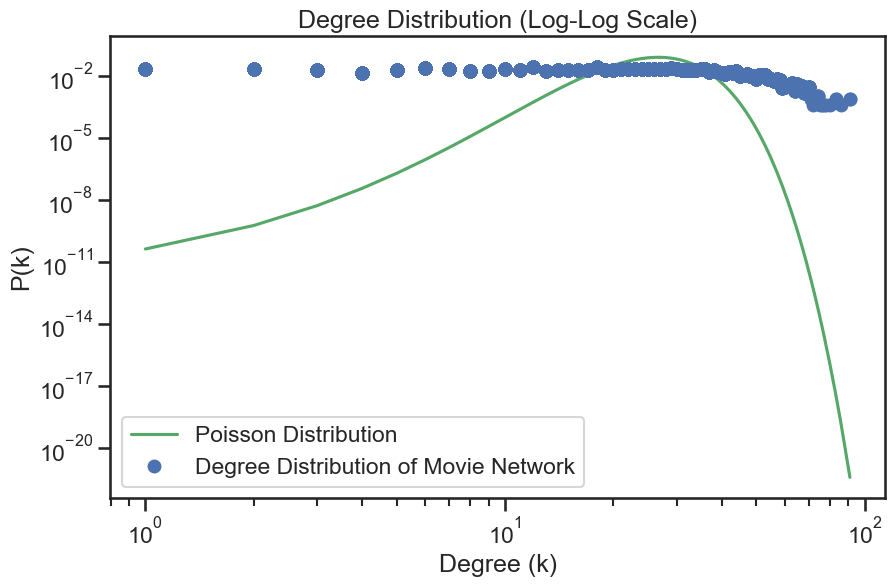

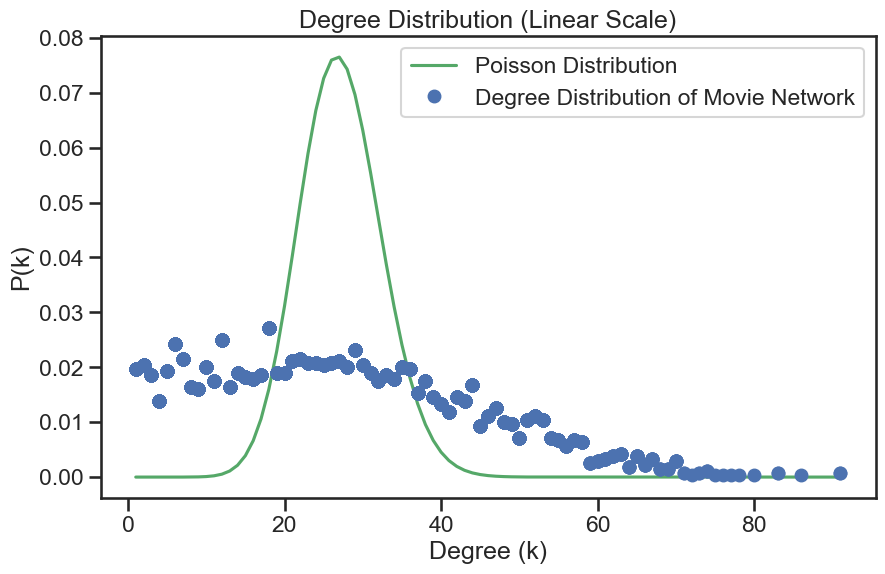

Slope: -0.25871 Intercept: -3.35039 R^2: 0.20514 P-value: 0.00000
3.295836866004329 -3.8594800456097342


In [620]:
# Plot the degree distribution
plt.figure(figsize=(10, 6))
# plt.loglog(degrees[degrees > 0], degree_count[degrees > 0], 'bo')  # Exclude zero degree entries
plt.loglog(degree_sequence,[math.exp(-average_degree) * (average_degree**d/math.factorial(d)) for d in degree_sequence] , 'g-')  
plt.loglog(degree_sequence_sorted,px, 'bo') 
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution (Log-Log Scale)")
plt.legend(["Poisson Distribution", "Degree Distribution of Movie Network"])
plt.show()


# Plot the degree distribution on a linear scale
plt.figure(figsize=(10, 6))
plt.plot(degree_sequence, [math.exp(-average_degree) * (average_degree**d/math.factorial(d)) for d in degree_sequence] , 'g-')  # Exclude zero degree entries
plt.plot(degree_sequence_sorted, [degree_sequence.count(d)/graph_no_isolated.number_of_nodes() for d in degree_sequence], 'bo')  
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution (Linear Scale)")
plt.legend(["Poisson Distribution", "Degree Distribution of Movie Network"])
plt.show()

# linear regression
log_degree = np.log(degree_sequence_sorted)
log_pk = np.log(px)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_degree,log_pk)
print(f"Slope: {slope:.5f} Intercept: {intercept:.5f} R^2: {r_value**2:.5f} P-value: {p_value:.5f}")
print(math.log(27), math.log(degree_sequence.count(27)/graph_no_isolated.number_of_nodes()))

### Plot the extracted largest component

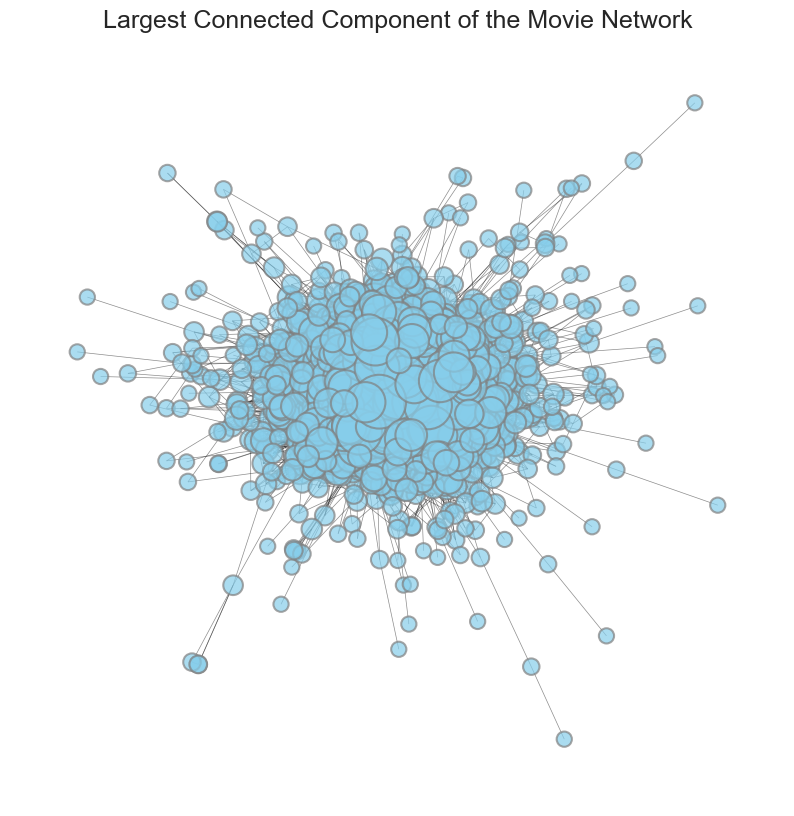

In [595]:
# Calculate node sizes based on degree in the subgraph
node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")

# Draw edges
nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

plt.title("Largest Connected Component of the Movie Network")
plt.axis("off")
plt.show()


### Network Visualisation

We used Graphistry tool to make an interactive visualisation of our network in order to use it in our presentation

In [596]:
# Data preprocessing for graphistry library needs

initial_pos = {n: np.random.rand(2) for n in graph_largest.nodes}
pos = nx.spring_layout(graph_largest, k=2.0, iterations=50, pos=initial_pos)

# Node DataFrame, including 'actors' attribute
nodes_df = pd.DataFrame.from_dict(dict(graph_largest.nodes(data=True)), orient='index')
nodes_df['degree'] = [graph_largest.degree[node] for node in graph_largest.nodes]
nodes_df['x'] = [pos[node][0] for node in graph_largest.nodes]
nodes_df['y'] =  [pos[node][1] for node in graph_largest.nodes]

# Edge DataFrame
edges_df = nx.to_pandas_edgelist(graph_largest)
edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

# Make the plot in the visualisation undirected
edges_df['edge'] = edges_df.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)
undirected_edges_df = edges_df.drop_duplicates(subset='edge').drop(columns='edge').reset_index(drop=True)

# Replace non-numeric values with NaN and convert column to numeric
nodes_df['domestic'] = pd.to_numeric(nodes_df['domestic'], errors='coerce')
nodes_df['international'] = pd.to_numeric(nodes_df['international'], errors='coerce')
nodes_df["run_time"] = pd.to_numeric(nodes_df["run_time"], errors='coerce')

In [597]:
# Bind the nodes and edges to Graphistry, specifying the source, destination, and node key
# Set up Graphistry (replace with your credentials or use environment variables)

graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="michalis", password="FDKeHQR4EQg7pvb")

graphistry.bind(source="source", destination="target", point_x="x", point_y="y") \
    .edges(undirected_edges_df) \
    .nodes(nodes_df.reset_index(), node="index") \
    .encode_point_size("degree") \
    .plot()

Failed memoization speedup attempt due to Pandas internal hash function failing. Continuing without memoization speedups.This is fine, but for speedups around skipping re-uploads of previously seen tables, try identifying which columns have types that Pandas cannot hash, and convert them to hashable types like strings.

## Network sentiment analysis

#### Node Sizes by Degree and Colors by Sentiment (Red to Green)

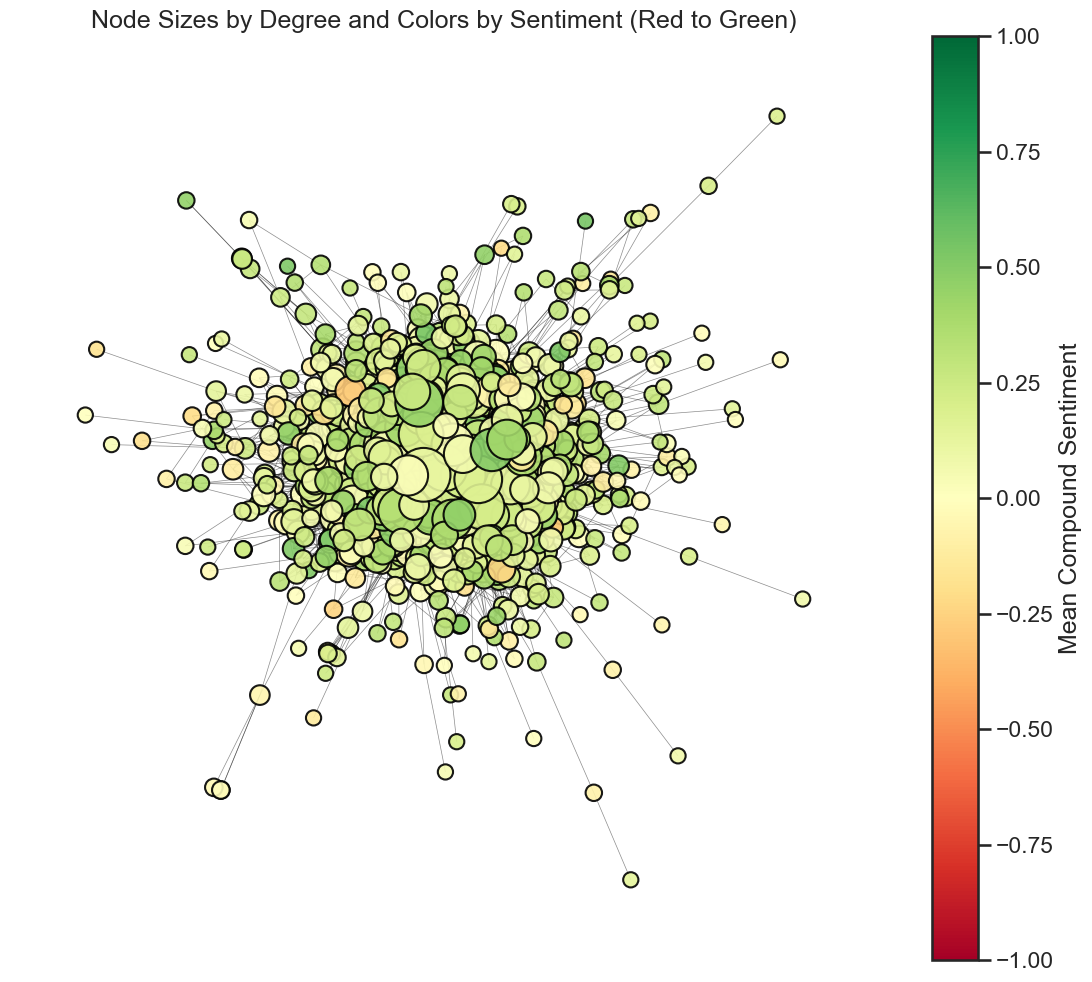

In [598]:
# Calculate node sizes based on degree in the subgraph
node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

# Extract sentiment values
sentiments = [graph_largest.nodes[node]['adjusted_sentiment'] for node in graph_largest.nodes]

# Map sentiment values to a Red-to-Green color gradient
norm = mcolors.Normalize(vmin=-1, vmax=1)  # Normalize between -1 and 1
cmap = cm.RdYlGn

# Create a ScalarMappable for the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(14, 12))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size (degree) and color (sentiment)
colors = [cmap(norm(sent)) for sent in sentiments]
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors="black")

nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

# Add the colorbar
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly associate the colorbar with the current axis
cbar.set_label("Mean Compound Sentiment")

plt.title("Node Sizes by Degree and Colors by Sentiment (Red to Green)")
plt.axis("off")
plt.show()

#### Distribution of Mean Compound Sentiment

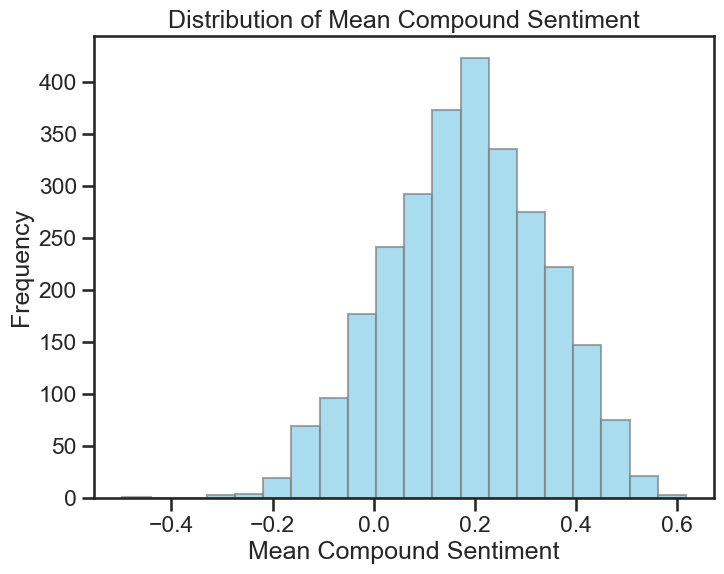

In [599]:
# Extract mean compound sentiment values
sentiments = [graph_largest.nodes[node]['adjusted_sentiment'] for node in graph_largest.nodes]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(sentiments, bins=20, color='skyblue', edgecolor='gray', alpha=0.7)
plt.title("Distribution of Mean Compound Sentiment")
plt.xlabel("Mean Compound Sentiment")
plt.ylabel("Frequency")
plt.show()


#### Average Sentiment Over Time

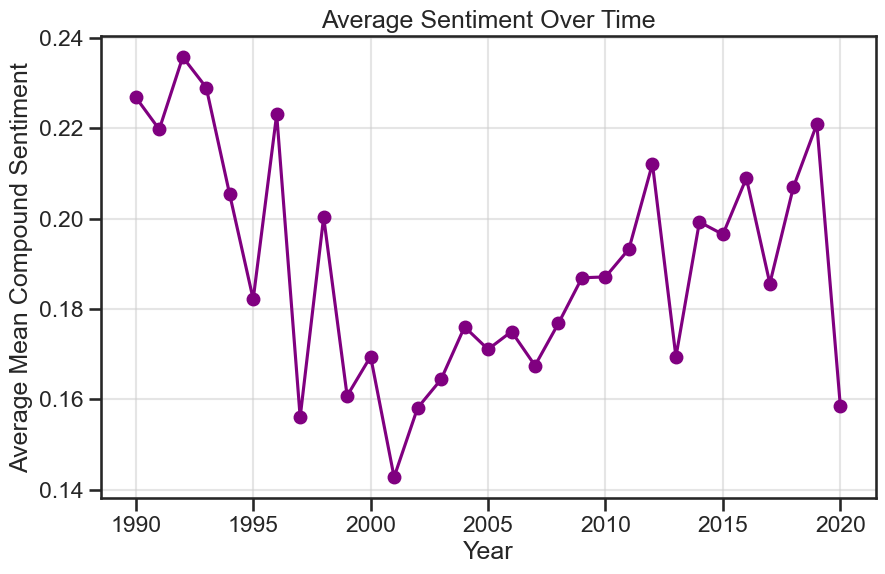

In [600]:
# Group sentiment by release year
years = [graph_largest.nodes[node]['release_year'] for node in graph_largest.nodes]
data = pd.DataFrame({'year': years, 'sentiment': sentiments})

# Calculate average sentiment per year
avg_sentiment_per_year = data.groupby('year')['sentiment'].mean()

# Line plot
plt.figure(figsize=(10, 6))
avg_sentiment_per_year.plot(color='purple', marker='o')
plt.title("Average Sentiment Over Time")
plt.xlabel("Year")
plt.ylabel("Average Mean Compound Sentiment")
plt.grid(alpha=0.5)
plt.show()


#### Top 10 Positive and Negative Sentiment Nodes

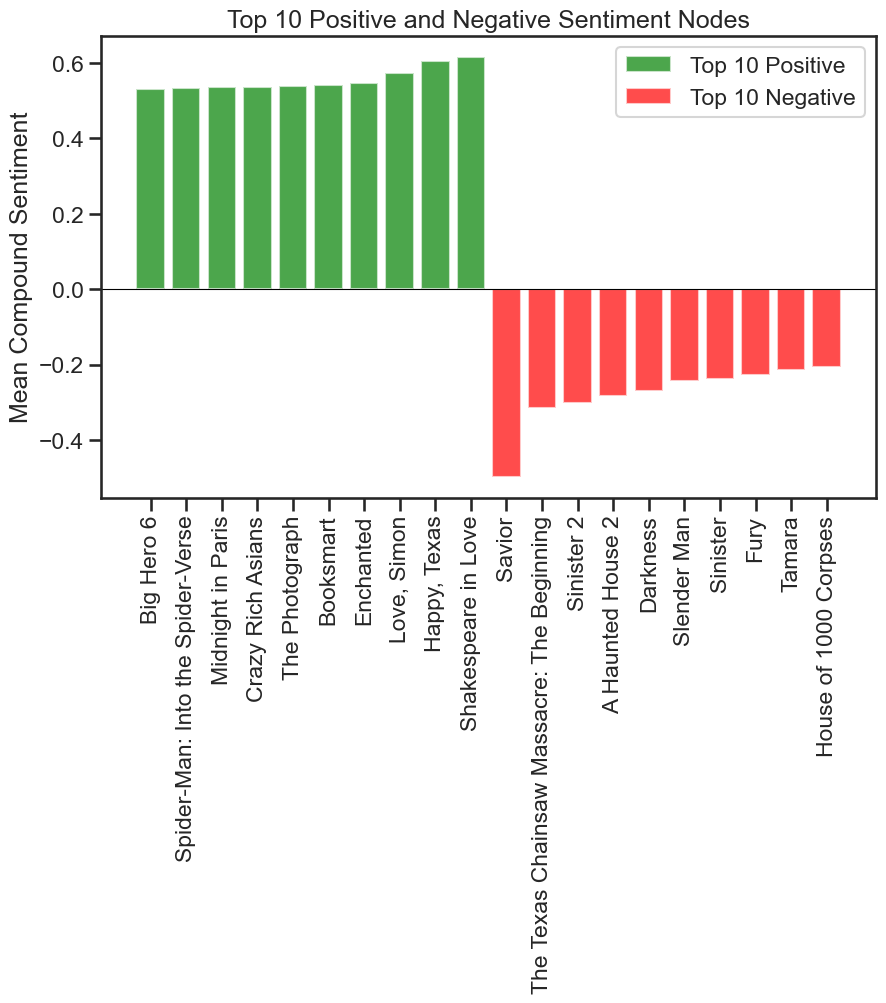

In [601]:
# Get top/bottom sentiment nodes
sorted_nodes = sorted(graph_largest.nodes, key=lambda node: graph_largest.nodes[node]['adjusted_sentiment'])
top_10 = sorted_nodes[-10:]
bottom_10 = sorted_nodes[:10]

# Data for plotting
top_sentiments = [graph_largest.nodes[node]['adjusted_sentiment'] for node in top_10]
bottom_sentiments = [graph_largest.nodes[node]['adjusted_sentiment'] for node in bottom_10]

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(10), top_sentiments, color='green', alpha=0.7, label="Top 10 Positive")
plt.bar(range(10, 20), bottom_sentiments, color='red', alpha=0.7, label="Top 10 Negative")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(range(20), labels=[*top_10, *bottom_10], rotation=90)
plt.title("Top 10 Positive and Negative Sentiment Nodes")
plt.ylabel("Mean Compound Sentiment")
plt.legend()
plt.show()


In [602]:
# make a dictionary with the actors and the number of movies they have played and the profit they have made
actor_to_movies.clear()
for movie in graph_largest.nodes:
    actors = graph_largest.nodes[movie].get('actors', [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)

    
actor_degree = {actor: len(actor_to_movies[actor]) for actor in actor_to_movies.keys()}

# Get top/bottom sentiment nodes
sorted_nodes = sorted(graph_largest.nodes, key=lambda node: graph_largest.nodes[node]['adjusted_sentiment'])
top_10 = sorted_nodes[-10:]
bottom_10 = sorted_nodes[:10]

# Data for plotting
top_sentiments = [graph_largest.nodes[node]['adjusted_sentiment'] for node in top_10]
bottom_sentiments = [graph_largest.nodes[node]['adjusted_sentiment'] for node in bottom_10]

sorted_top_movies = sorted(top_10, key=lambda movie: graph_largest.nodes[movie]["adjusted_sentiment"], reverse=True)
print("\ntop_10")
for movie in sorted_top_movies:
    print(movie)
    print(graph_largest.nodes[movie]["adjusted_sentiment"])
    for actor in (graph_largest.nodes[movie]["actors"]):
        print(actor, actor_degree[actor])
    print("\n")
        
sorted_bottom_movies = sorted(bottom_10, key=lambda movie: graph_largest.nodes[movie]["adjusted_sentiment"])
print("\nbottom_10")
for movie in sorted_bottom_movies:
    print(movie)
    print(graph_largest.nodes[movie]["adjusted_sentiment"])
    for actor in (graph_largest.nodes[movie]["actors"]):
        print(actor, actor_degree[actor])
    print("\n")


top_10
Shakespeare in Love
0.6174713845304877
Gwyneth Paltrow 14
Joseph Fiennes 7
Geoffrey Rush 11
Tom Wilkinson 13


Happy, Texas
0.606459341528963
Jeremy Northam 6
Steve Zahn 12
William H. Macy 8
Ally Walker 1


Love, Simon
0.5745042125814742
Nick Robinson 2
Jennifer Garner 16
Josh Duhamel 8
Katherine Langford 1


Enchanted
0.5467375570456698
Amy Adams 14
Susan Sarandon 16
James Marsden 12
Patrick Dempsey 5


Booksmart
0.5428855148210809
Kaitlyn Dever 1
Beanie Feldstein 1
Jessica Williams 1
Jason Sudeikis 7


The Photograph
0.539625731313921
Chelsea Peretti 1
LaKeith Stanfield 2
Courtney B. Vance 1
Issa Rae 1


Crazy Rich Asians
0.537666233584769
Constance Wu 2
Henry Golding 2
Michelle Yeoh 5
Gemma Chan 1


Midnight in Paris
0.5363044286112935
Owen Wilson 22
Rachel McAdams 14
Kathy Bates 13
Kurt Fuller 2


Spider-Man: Into the Spider-Verse
0.5331272047140364
Shameik Moore 2
Jake Johnson 3
Hailee Steinfeld 7
Mahershala Ali 5


Big Hero 6
0.5310499416810326
Ryan Potter 1
Scott Adsit 1

#### Comparing the sentiment calculated with the Rotten Tomato critic score.

In [603]:
scores = [(movie_graph.nodes[movie]['mean_compound_sentiment'], graph_largest.nodes[movie]['tomatoMeter']) 
          for movie in graph_largest.nodes
          if not (np.isnan(graph_largest.nodes[movie]['mean_compound_sentiment']) or np.isnan(graph_largest.nodes[movie]['tomatoMeter']) or
                   np.isinf(graph_largest.nodes[movie]['mean_compound_sentiment']) or np.isinf(graph_largest.nodes[movie]['tomatoMeter']))]

# Correlation between the sentiment of the movie and the tomatoMeter
pearson_corr, pearson_p = stats.pearsonr([score[0] for score in scores], [score[1] for score in scores])
spearman_corr, spearman_p = stats.spearmanr([score[0] for score in scores], [score[1] for score in scores])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.9f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.9f})")

Pearson correlation: 0.544 (p-value: 0.000000000)
Spearman correlation: 0.549 (p-value: 0.000000000)


Text(0, 0.5, 'TomatoMeter')

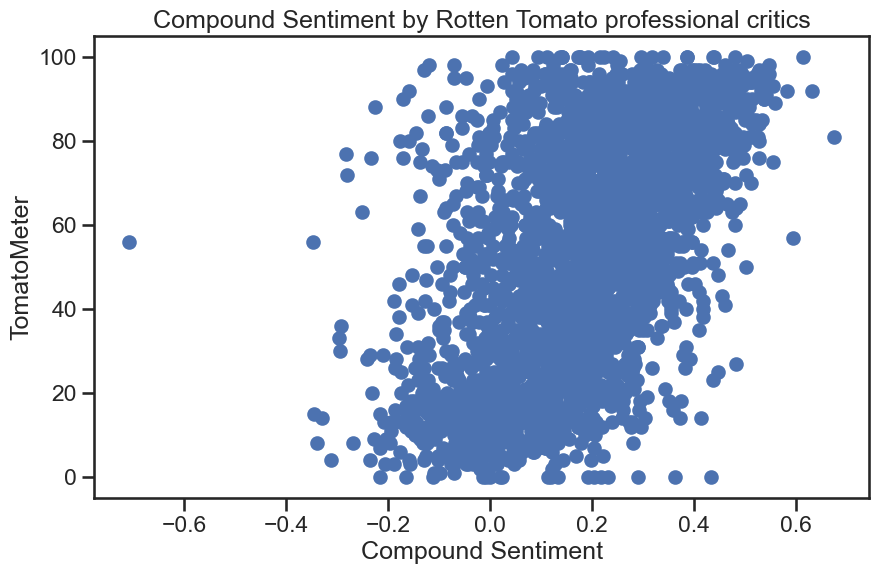

In [604]:
# compare with the sentiment
fig2, ax3 = plt.subplots(figsize=(10, 6))
ax3.scatter([score[0] for score in scores], [score[1] for score in scores])
ax3.set_title("Compound Sentiment by Rotten Tomato professional critics")
ax3.set_xlabel("Compound Sentiment")
ax3.set_ylabel("TomatoMeter")

#### Network homophily based on sentiment

Homophily measures the tendency of individuals to associate and bond with similar others in a network. In our case, we will calculate how similar the sentiments of connected movies are. This could reveal if actor-driven sentiment spreads across the network

In [605]:
# Shuffle graph edges
nswap = 10 * graph.number_of_edges()
shuffled_graph = nx.double_edge_swap(graph.copy(), nswap=nswap, max_tries=nswap * 2)

# Define similarity function for shuffled graph
adjusted_sentiment_per_node = nx.get_node_attributes(graph, 'adjusted_sentiment')
range_of_values = max(adjusted_sentiment_per_node.values()) - min(adjusted_sentiment_per_node.values())

def similarity(u, v):
    return 1 - abs(adjusted_sentiment_per_node[u] - adjusted_sentiment_per_node[v]) / range_of_values

# Calculate observed mean similarity
similarities = [similarity(u, v) for u, v in graph.edges]
mean_similarity_observed = np.mean(similarities)

# Calculate null mean similarity on shuffled graph
null_similarities = [similarity(u, v) for u, v in shuffled_graph.edges]
mean_similarity_null = np.mean(null_similarities)

# Compare observed and null similarities
homophily_index = (mean_similarity_observed - mean_similarity_null) / mean_similarity_null

print(f"Observed Mean Similarity: {mean_similarity_observed}")
print(f"Null Mean Similarity: {mean_similarity_null}")
print(f"Homophily Index: {homophily_index}")


Observed Mean Similarity: 0.8592399754167914
Null Mean Similarity: 0.8511373522327949
Homophily Index: 0.009519759839867092


Homophily index value is approximately 0.01. This indicates that nodes that are connected do not have a much larger similarity of sentiment than they would have if they were randomly connected.


## Statistics on The Largest Component  
The next few block will show that there is correlation between the success metrics (profits, sentiment) and the popularity of the actors.

This block will prepare data for analysis. it will do the following 
- update the `actors_to_movies` dictionary such that actor wll be a key and the list of movies they acted in will be the value
- create an `actor_degree` dictionary which will have actors as keys and how many movies they acted in as values
- create an `actor_avg_earning` dictionary which will have actors as keys and the mean of the profit of the movies they acted in
- create an `actor_avg_sentiment` dictionary which will have actors as keys and the mean of the sentiment of the reviews of the movies they acted in
- converting the dictionaries to lists, the average sentiment of the first element will refer to the same actor in another list

In [606]:
# Preparing the data for the analysis

# make a dictionary with the actors and the number of movies they have played and the profit they have made
actor_to_movies.clear()
for movie in graph_largest.nodes:
    actors = graph_largest.nodes[movie].get('actors', [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)

    
actor_degree = {actor: len(actor_to_movies[actor]) for actor in actor_to_movies.keys()}
actor_avg_earning = {actor: np.mean([graph_largest.nodes[movie]['profit'] for movie in actor_to_movies[actor]]) for actor in actor_to_movies.keys()}
actor_avg_sentiment = {actor: np.mean([graph_largest.nodes[movie]['adjusted_sentiment'] for movie in actor_to_movies[actor]]) for actor in actor_to_movies.keys()}

# convert the dictionaries to lists
keys = sorted(set(actor_degree.keys()) | set(actor_avg_earning.keys()))
actor_degree_ls = [actor_degree.get(k) for k in keys]
actor_avg_earning_ls = [actor_avg_earning.get(k) for k in keys]

keys = sorted(set(actor_degree.keys()) | set(actor_avg_sentiment.keys()))
actor_sentiment_ls = [actor_degree.get(k) for k in keys]
actor_avg_sentiment_ls = [actor_avg_sentiment.get(k) for k in keys]

Here we calculate the following metrics for the popularity of the actors and profits
- Pearson correlation 
- Pearson p-value for the null hypothesist that they are uncorrelated
- same using Spearman correlation
- a simple linear regression between the popularity of the actors and profits that returns the slope, intercept, standard error estimate of the slope
NOTE the linear regression is done by getting the mean of all the (mean) profits for the actors that have acted in the same number of movies, i.e  if 2 actors acted in 2 movies the mean of the profit generated by each actor is again averaged.   

In [607]:
# Calculate the Pearson and Spearman correlation coefficients
pearson_corr, pearson_p = stats.pearsonr(actor_degree_ls, actor_avg_earning_ls)
spearman_corr, spearman_p = stats.spearmanr(actor_degree_ls, actor_avg_earning_ls)

print(f"""
Pearson correlation between a movie's cast popularity and average earnings: {pearson_corr:.3f} (p-value: {pearson_p:.3f})
""")
print(f"Spearman correlation between a movie's cast popularity and average earnings:: {spearman_corr:.3f} (p-value: {spearman_p:.3f})\n")

# calculate the mean profit for each "level" of actor popularity
# simple linear regression
mean_by_degree = dict()
for degree, earning in zip(actor_degree_ls, actor_avg_earning_ls):
    if degree not in mean_by_degree:
        mean_by_degree.update({degree: [earning]})
    else:
        mean_by_degree[degree].append(earning)
mean_by_degree = {degree: np.mean(earnings) for degree, earnings in mean_by_degree.items()}

slope, intercept, r, p, std_err = stats.linregress([key for key in mean_by_degree.keys()], [value for value in mean_by_degree.values()])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")


Pearson correlation between a movie's cast popularity and average earnings: 0.118 (p-value: 0.000)

Spearman correlation between a movie's cast popularity and average earnings:: 0.261 (p-value: 0.000)

Linear regression: slope=1353420.173, intercept=72040614.125, r=0.572, p=0.001, std_err=360477.597


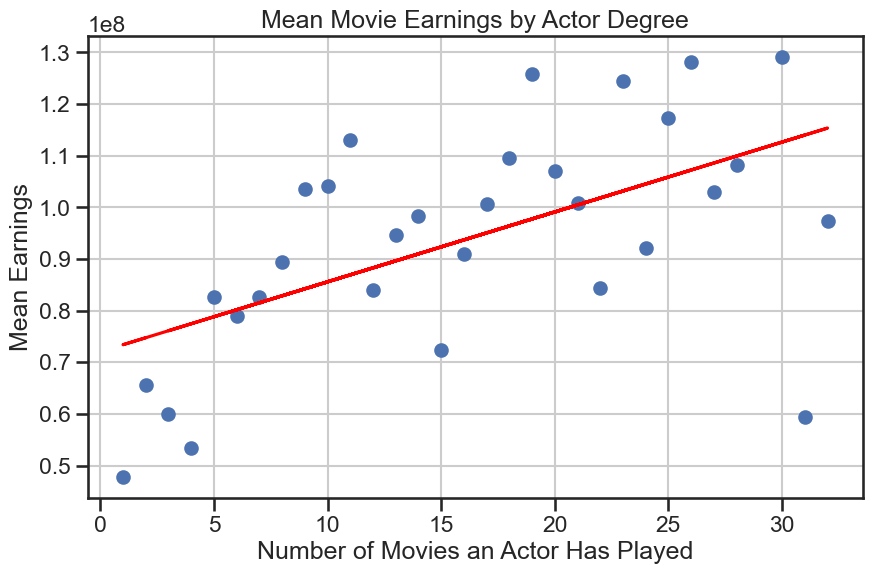

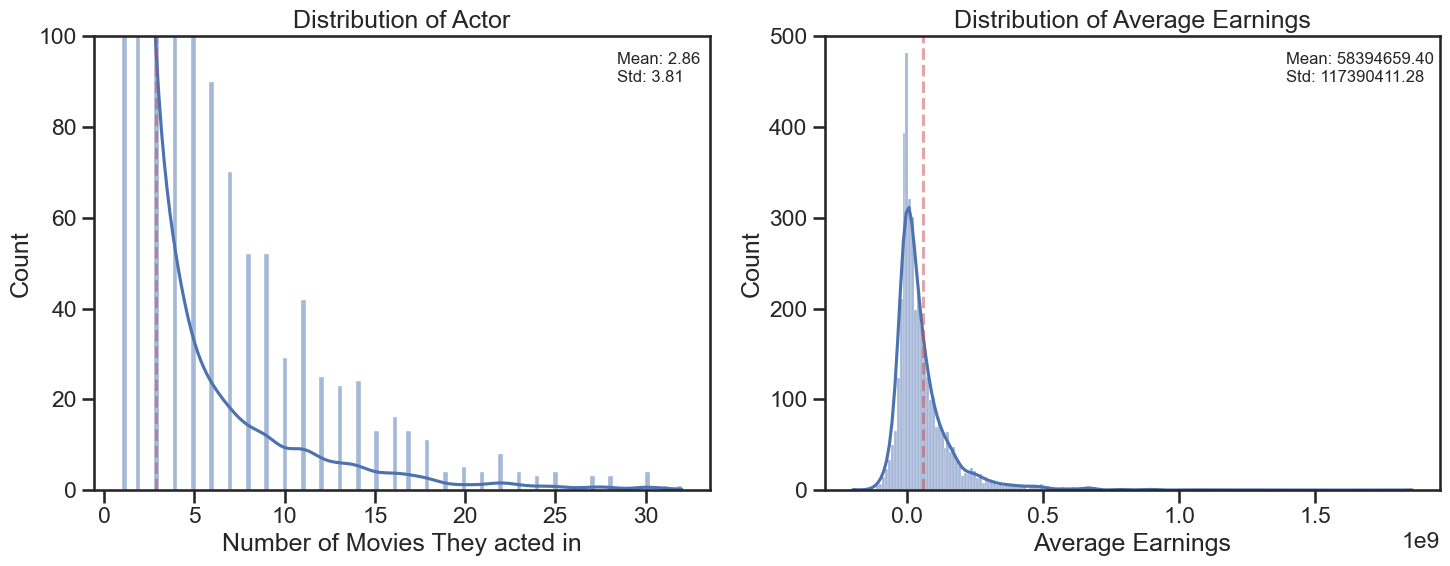

In [608]:
# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(mean_by_degree.keys(), mean_by_degree.values())
plt.plot([key for key in mean_by_degree.keys()], [slope * key + intercept for key in mean_by_degree.keys()], color='red')  
plt.xlabel('Number of Movies an Actor Has Played')
plt.ylabel('Mean Earnings')
plt.title('Mean Movie Earnings by Actor Degree')
plt.grid(True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Actor Degrees Distribution
sns.histplot(actor_degree_ls, kde=True, ax=ax1)
ax1.set_title('Distribution of Actor')
ax1.set_xlabel('Number of Movies They acted in')
ax1.set_ylabel('Count')
ax1.set_ylim(0, 100)

# Add mean and std annotations
mean_degree = np.mean(actor_degree_ls)
std_degree = np.std(actor_degree_ls)
ax1.axvline(mean_degree, color='r', linestyle='--', alpha=0.5)
ax1.text(0.85, 0.9, f'Mean: {mean_degree:.2f}\nStd: {std_degree:.2f}', 
         transform=ax1.transAxes, fontsize=12)

# Plot 2: Average Earnings Distribution
sns.histplot(actor_avg_earning_ls, kde=True, ax=ax2)
ax2.set_title('Distribution of Average Earnings')
ax2.set_xlabel('Average Earnings')
ax2.set_ylabel('Count')
ax2.set_ylim(0, 500)

# Add mean and std annotations
mean_earning = np.mean(actor_avg_earning_ls)
std_earning = np.std(actor_avg_earning_ls)
ax2.axvline(mean_earning, color='r', linestyle='--', alpha=0.5)
ax2.text(0.75, 0.90, f'Mean: {mean_earning:.2f}\nStd: {std_earning:.2f}', 
         transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.show()

Here we calculate the following metrics for the popularity of the actors and sentiment
- Pearson correlation 
- Pearson p-value for the null hypothesist that they are uncorrelated
- same using Spearman correlation
- a simple linear regression between the popularity of the actors and sentiment that returns the slope, intercept, standard error estimate of the slope


NOTE the linear regression is done by getting the mean of all the (mean) profits for the actors that have acted in the same number of movies, i.e  if 2 actors acted in 2 movies the mean of the sentiment by each actor is again averaged.   

In [609]:
## correlation between the popularity of the actors and the sentiment
pearson_corr, pearson_p = stats.pearsonr(actor_degree_ls, actor_avg_sentiment_ls)
spearman_corr, spearman_p = stats.spearmanr(actor_degree_ls, actor_avg_sentiment_ls)

print(f"Pearson correlation between a movie's cast popularity and average reviews sentiment: {pearson_corr:.3f} (p-value: {pearson_p:.4f})")
print(f"Spearman correlation between a movie's cast popularity and average reviews sentiment: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")

Pearson correlation between a movie's cast popularity and average reviews sentiment: 0.063 (p-value: 0.0001)
Spearman correlation between a movie's cast popularity and average reviews sentiment: 0.047 (p-value: 0.0031)


In [610]:
# simple linear regression sentiment
slope, intercept, r, p, std_err = stats.linregress(actor_degree_ls,actor_avg_sentiment_ls)
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")

# simple linear regression for the dict where it shows the mean sentiment for each "level" of actor popularity
mean_by_degree_sen = dict()
for degree, sentiment in zip(actor_degree_ls, actor_avg_sentiment_ls):
    if degree not in mean_by_degree_sen:
        mean_by_degree_sen.update({degree: [sentiment]})
    else:
        mean_by_degree_sen[degree].append(sentiment)
mean_by_degree_sen = {degree: np.mean(earnings) for degree, earnings in mean_by_degree_sen.items()}

slope, intercept, r, p, std_err = stats.linregress([key for key in mean_by_degree_sen.keys()], [value for value in mean_by_degree_sen.values()])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")

##Result not linear

Linear regression: slope=0.002, intercept=0.164, r=0.063, p=0.000, std_err=0.001
Linear regression: slope=-0.000, intercept=0.191, r=-0.042, p=0.823, std_err=0.001


Text(0, 0.5, 'Frequency')

<Figure size 1000x600 with 0 Axes>

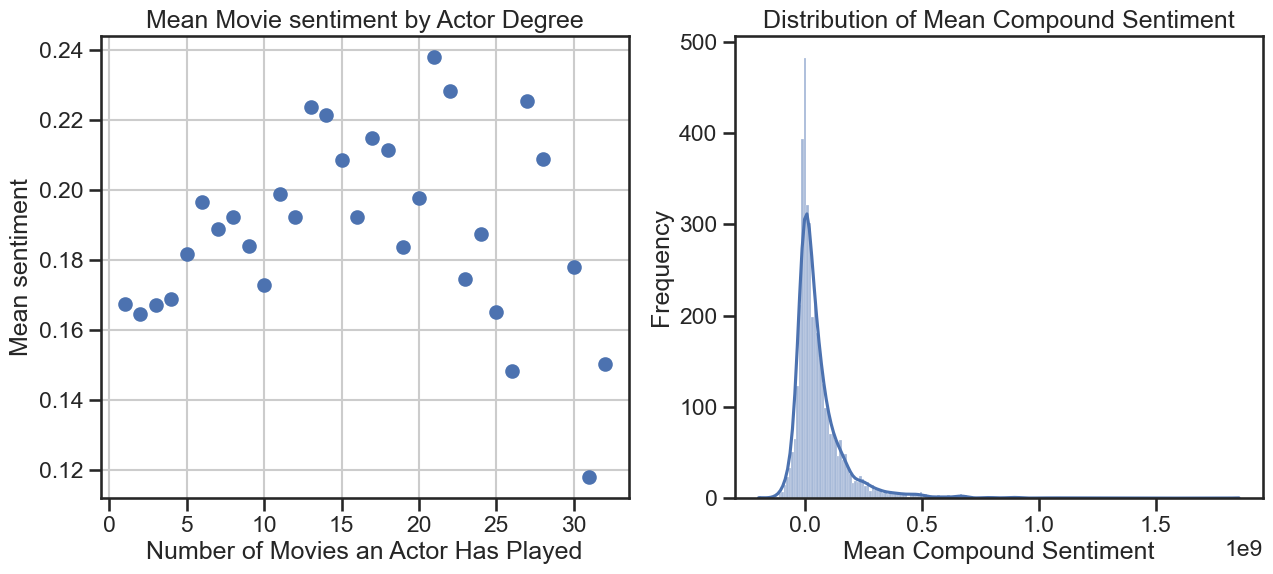

In [611]:
# Plot results
plt.figure(figsize=(10, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(mean_by_degree_sen.keys(), mean_by_degree_sen.values())
ax1.set_xlabel('Number of Movies an Actor Has Played')
ax1.set_ylabel('Mean sentiment')
ax1.set_title('Mean Movie sentiment by Actor Degree')
ax1.grid(True)

# histogram of the sentiment
sns.histplot(actor_avg_earning_ls, kde=True, ax=ax2)
ax2.set_title("Distribution of Mean Compound Sentiment")
ax2.set_xlabel("Mean Compound Sentiment")
ax2.set_ylabel("Frequency")

#### Total actor popularity compared with earnings and sentiment

In [612]:
# Find actor popularity in movies
appearances = nx.get_node_attributes(graph, 'actors')
flattened_appearances_list = list(chain.from_iterable(list(appearances.values())))
appearances_count = Counter(flattened_appearances_list)

# Add total popularity attribute
for node in graph.nodes:
    total_actor_popularity = sum([appearances_count[actor] for actor in appearances[node]])
    graph.nodes[node]["total_actor_popularity"] = total_actor_popularity

# Calculate the Pearson and Spearman correlation coefficients for total popularity and profit
total_actor_popularity = list(nx.get_node_attributes(graph, "total_actor_popularity").values())
profit = list(nx.get_node_attributes(graph, "profit").values())
pearson_corr, pearson_p = stats.pearsonr(total_actor_popularity, profit)
spearman_corr, spearman_p = stats.spearmanr(total_actor_popularity, profit)

print(f"---- Total actor popularity vs profit ----")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

# Calculate the Pearson and Spearman correlation coefficients for total popularity and profit
adjusted_sentiment = list(nx.get_node_attributes(graph, "adjusted_sentiment").values())
pearson_corr, pearson_p = stats.pearsonr(total_actor_popularity, adjusted_sentiment)
spearman_corr, spearman_p = stats.spearmanr(total_actor_popularity, adjusted_sentiment)

print(f"\n---- Total actor popularity vs sentiment ----")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

---- Total actor popularity vs profit ----
Pearson correlation: 0.175 (p-value: 0.000)
Spearman correlation: 0.164 (p-value: 0.000)

---- Total actor popularity vs sentiment ----
Pearson correlation: 0.133 (p-value: 0.000)
Spearman correlation: 0.128 (p-value: 0.000)


### Centrality

Here we calculate the centrality metrics for 
- Betweenness centrality : Measures how often a node acts as a bridge along the shortest path between two other nodes.
- Eigenvector_centrality : Measures a node's importance based on the importance of its neighbors.
- Degree_centrality : Measures the proportion of direct connections a node has relative to the total possible connections
- Edge_betweenness_centrality : Measures how often an edge is part of the shortest paths between pairs of nodes

In [613]:
bet_cent = nx.betweenness_centrality(graph_largest)

eig_cent = nx.eigenvector_centrality(graph_largest)

deg_cent = nx.degree_centrality(graph_largest)

edge_bet = nx.edge_betweenness_centrality(graph_largest)

#### Top 5 movies/actors for each centrality metrics

In [614]:
top5Edges = sorted(edge_bet.items(), key=lambda x: x[1], reverse=True)[:5]
top5actors = []
for edge in top5Edges:
    movie1, movie2 = edge[0]
    for actor in graph_largest.nodes[movie1]['actors']:
        if actor in graph_largest.nodes[movie2]['actors']:
            top5actors.append(actor)

print("Top 5 actors in edges with the highest betweenness centrality", top5actors)
print("\nTop 5 nodes with the highest betweenness centrality", sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5])
print("\nTop 5 nodes with the highest eigenvector centrality", sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:5])
print("\nTop 5 nodes with the highest degree centrality", sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 actors in edges with the highest betweenness centrality ['Ben Mendelsohn', 'Angus Macfadyen', 'James DeBello', 'Dean Cain', 'Mackenzie Davis']

Top 5 nodes with the highest betweenness centrality [('Shark Tale', 0.004288706495710224), ('Pain & Gain', 0.004086286152985749), ('The Ant Bully', 0.003932049550063262), ('Captain Marvel', 0.0036510740547660513), ('Nurse Betty', 0.0032868787241085353)]

Top 5 nodes with the highest eigenvector centrality [("Ocean's Eleven", 0.09519889797752502), ('The Departed', 0.08486878846390782), ('Shark Tale', 0.07145619545278582), ("Ocean's Twelve", 0.07062921543648402), ('The Perfect Storm', 0.0700681496495838)]

Top 5 nodes with the highest degree centrality [("Ocean's Eleven", 0.032780979827089336), ('Shark Tale', 0.032780979827089336), ('The Ant Bully', 0.030979827089337175), ('Alexander', 0.029899135446685876), ('The Departed', 0.029899135446685876)]


#### Plot centrality vs success metrics

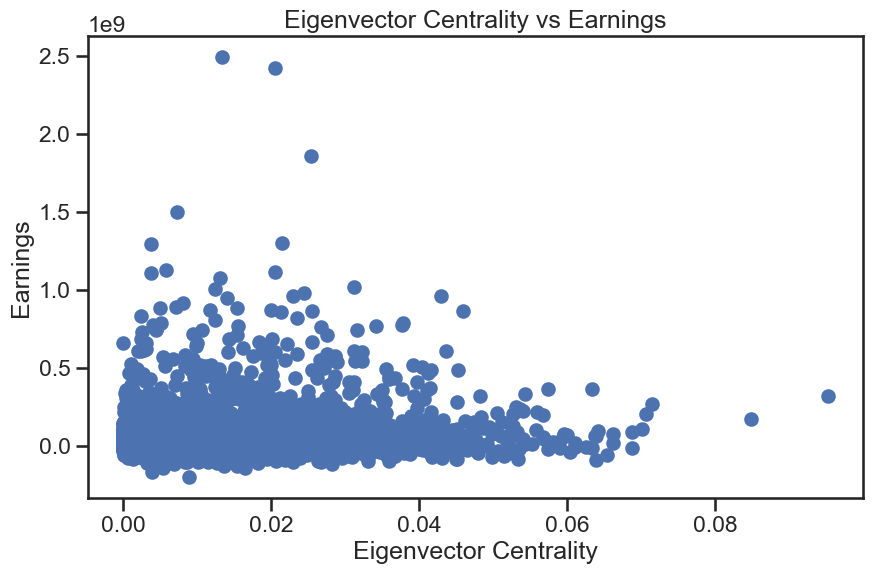

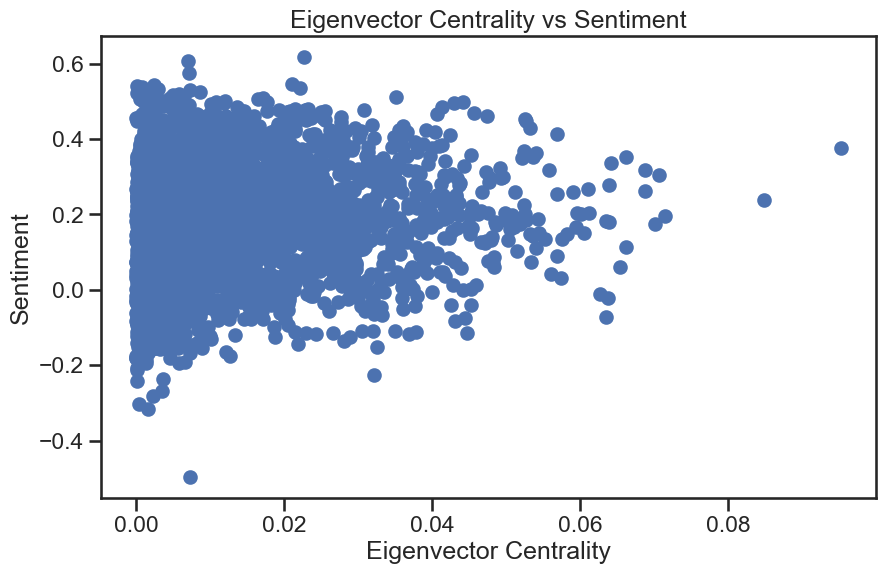

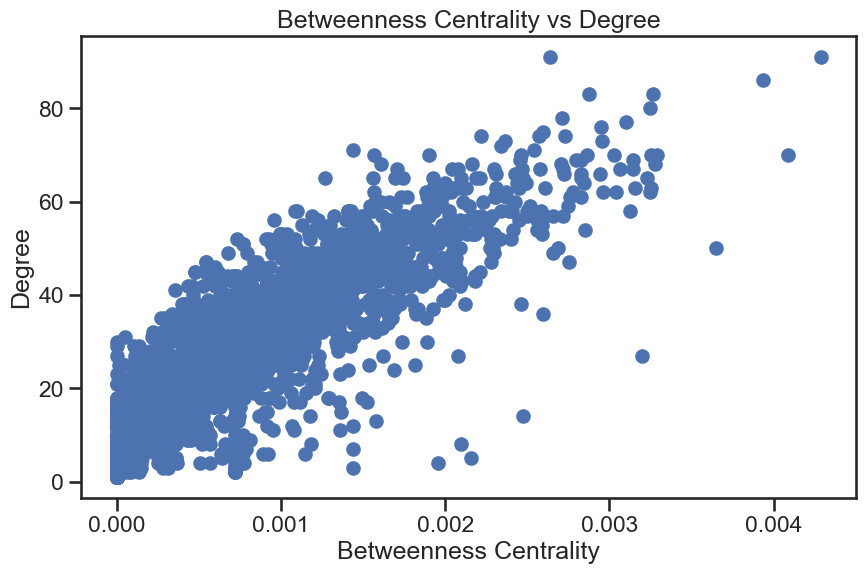

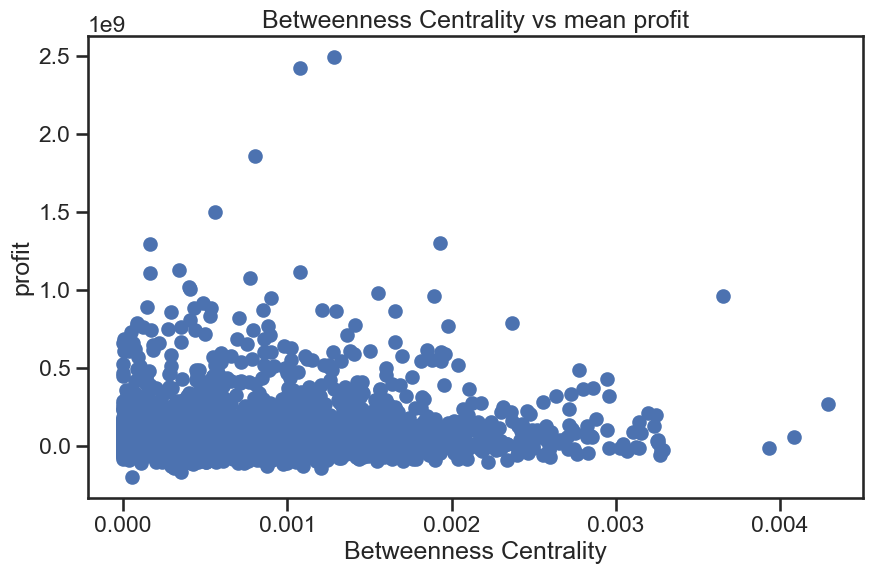

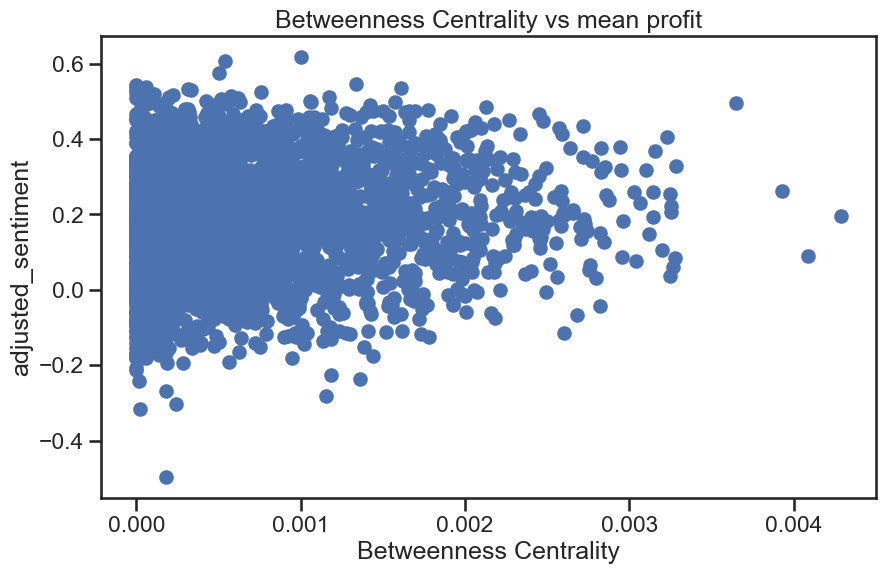

Michael J. Fox


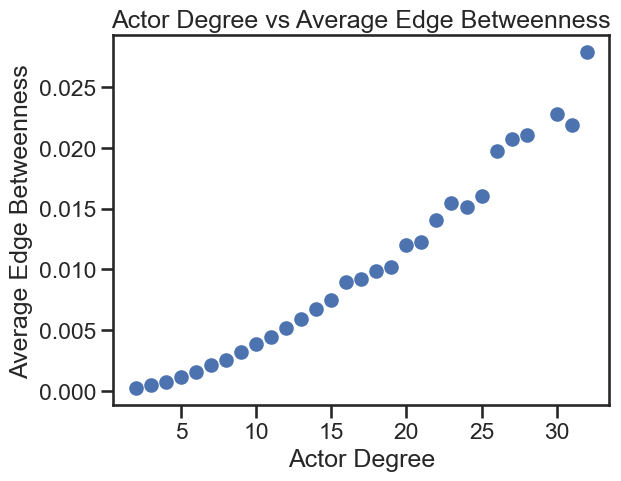

In [615]:
plt.figure(figsize=(10, 6))
plt.scatter([eig_cent[node] for node in graph_largest.nodes()],
            [graph_largest.nodes(data=True)[node]["profit"] for node in graph_largest.nodes()])
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Earnings")
plt.title("Eigenvector Centrality vs Earnings")
# plt.ylim(0, 100_000_000)
plt.show()

# Plot eigenvector centrality vs sentiment
plt.figure(figsize=(10, 6))
plt.scatter([eig_cent[node] for node in graph_largest.nodes()],
            [graph_largest.nodes(data=True)[node]["adjusted_sentiment"] for node in graph_largest.nodes()])
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Sentiment")
plt.title("Eigenvector Centrality vs Sentiment")
# plt.ylim(0, 10_000_000)
plt.show()

# Plot betweenness centrality vs degree
plt.figure(figsize=(10, 6))
plt.scatter([bet_cent[node] for node in graph_largest.nodes()],
            [graph_largest.degree(node)  for node in graph_largest.nodes()])
plt.xlabel("Betweenness Centrality")
plt.ylabel("Degree")
plt.title("Betweenness Centrality vs Degree")
plt.show()

# Plot betweenness centrality vs degree
plt.figure(figsize=(10, 6))
plt.scatter([bet_cent[node] for node in graph_largest.nodes()],
            [graph_largest.nodes(data=True)[node]["profit"] for node in graph_largest.nodes()])
plt.xlabel("Betweenness Centrality")
plt.ylabel("profit")
plt.title("Betweenness Centrality vs mean profit")
plt.show()
# Plot betweenness centrality vs adjusted_sentiment
plt.figure(figsize=(10, 6))
plt.scatter([bet_cent[node] for node in graph_largest.nodes()],
            [graph_largest.nodes(data=True)[node]["adjusted_sentiment"] for node in graph_largest.nodes()])
plt.xlabel("Betweenness Centrality")
plt.ylabel("adjusted_sentiment")
plt.title("Betweenness Centrality vs mean profit")
plt.show()
# edge betweenness centrality vs actor degree

print(graph_largest[next(iter(edge_bet))[0]][next(iter(edge_bet))[1]]['actor'])
average_actor_betweeeness = [(graph_largest[edge[0]][edge[1]]["actor"], score) 
                             for edge, score in edge_bet.items()]
average_actor_betweeeness =  {k: sum(v[1] for v in average_actor_betweeeness if v[0] == k) for k in set(x[0] for x in average_actor_betweeeness)}

mean_by_degree = {}
for actor in average_actor_betweeeness.keys():
    degree = actor_degree[actor]
    if degree not in mean_by_degree:
        mean_by_degree[degree] = []
    mean_by_degree[degree].append(average_actor_betweeeness[actor])

mean_by_degree = {k: np.mean(v) for k, v in mean_by_degree.items()}
# plt.scatter([actor_degree[actor] for actor in average_actor_betweeeness.keys()],
#             [average_actor_betweeeness[actor] for actor in average_actor_betweeeness.keys()])
plt.scatter(mean_by_degree.keys(), mean_by_degree.values())
plt.xlabel("Actor Degree")
plt.ylabel("Average Edge Betweenness")
plt.title("Actor Degree vs Average Edge Betweenness")
plt.show()

#### Correlation between centrality and success metrics

In [625]:
slope, intercept, r, p, std_err = stats.linregress([cent for _ , cent in eig_cent.items() ],[graph_largest.nodes[name]["profit"] for name,_ in eig_cent.items() ])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")
slope, intercept, r, p, std_err = stats.linregress([cent for _,cent in deg_cent.items() ],[graph_largest.nodes[name]["profit"] for name,_ in deg_cent.items() ])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")
slope, intercept, r, p, std_err = stats.linregress([cent for _,cent in bet_cent.items() ],[graph_largest.nodes[name]["profit"] for name,_ in bet_cent.items() ])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")


print("-------------------")
# corelation between the profit and the centrality measures
# Eigenvector centrality
print("Eigenvector centrality")
print("Profit")
spearman_corr, spearman_p = stats.spearmanr([cent for _,cent in eig_cent.items()],[graph_largest.nodes[name]["profit"] for name,_ in eig_cent.items() ])
print(f"Spear man correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")
print("Sentiment")
spearman_corr, spearman_p = stats.spearmanr([cent for _,cent in eig_cent.items()],[graph_largest.nodes[name]["adjusted_sentiment"] for name,_ in eig_cent.items() ])
print(f"Spear man correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")
# Degree centrality
print("Degree centrality")
print("Profit")
spearman_corr, spearman_p = stats.spearmanr([cent for _,cent in deg_cent.items()],[graph_largest.nodes[name]["profit"] for name,_ in deg_cent.items() ])
print(f"Spearmann correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")
print("Sentiment")
spearman_corr, spearman_p = stats.spearmanr([cent for _,cent in deg_cent.items()],[graph_largest.nodes[name]["adjusted_sentiment"] for name,_ in deg_cent.items() ])
print(f"Spear man correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")
# Betweenness centrality
print("Betweenness centrality")
print("Profit")
spearman_corr, spearman_p = stats.spearmanr([cent for _,cent in bet_cent.items()],[graph_largest.nodes[name]["profit"] for name,_ in bet_cent.items() ])
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")
print("Sentiment")
spearman_corr, spearman_p = stats.spearmanr([cent for _,cent in bet_cent.items()],[graph_largest.nodes[name]["adjusted_sentiment"] for name,_ in bet_cent.items() ])
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")
# Edge betweenness centrality
print("Edge Betweenness centrality")
spearman_corr, spearman_p = stats.spearmanr(list(mean_by_degree.keys()), list(mean_by_degree.values()))
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")
print("-------------------")

Linear regression: slope=1535615816.000, intercept=55883582.418, r=0.114, p=0.000, std_err=254241670.456
Linear regression: slope=4304282219.123, intercept=34716685.877, r=0.147, p=0.000, std_err=548099182.060
Linear regression: slope=22692300284.807, intercept=59916598.958, r=0.087, p=0.000, std_err=4951337901.231
-------------------
Eigenvector centrality
Profit
Spear man correlation: 0.129 (p-value: 0.0000)
Sentiment
Spear man correlation: 0.118 (p-value: 0.0000)
Degree centrality
Profit
Spearmann correlation: 0.147 (p-value: 0.0000)
Sentiment
Spear man correlation: 0.121 (p-value: 0.0000)
Betweenness centrality
Profit
Spearman correlation: 0.106 (p-value: 0.0000)
Sentiment
Spearman correlation: 0.087 (p-value: 0.0000)
Edge Betweenness centrality
Spearman correlation: 0.999 (p-value: 0.0000)
-------------------


## Community analysis

In [627]:
##Functions to calculate modularity
def dict_to_subgraphs(communities,G):
  subgraphs = []
  for key in communities.keys():
    nodes = communities[key]
    subgraph = G.subgraph(nodes)
    subgraphs.append(subgraph)
  return subgraphs

def modularity(subgraphs,G):
  L_c = [subgraph.number_of_edges() for subgraph in subgraphs]
  K_c = [sum([G.degree(node) for node in subgraph.nodes()]) for subgraph in subgraphs]
  M = sum([
    (L_c[i]/G.number_of_edges())-
    ((K_c[i]/(2*G.number_of_edges()))**2) for i in range(len(L_c))])
  return M

### Communities by genre

#### Create communities based on the first genre of a movie

In [628]:
## Find communities based on the first genre G
communities_first_genre = dict()
for node in graph_largest.nodes():
    if graph_largest.nodes(data=True)[node]["genres"][0] != "UNKNOWN":
        community = graph_largest.nodes(data=True)[node]["genres"][0]

        if community in communities_first_genre.keys():
            current = communities_first_genre[community]
            current.append(node)
            communities_first_genre[community]=current
        else:
            communities_first_genre.update({community:[node]})

num_communities = len(communities_first_genre)
print(f"Number of communities: {num_communities}")
print("Modularity based on genre", modularity(dict_to_subgraphs(communities_first_genre,graph_largest),graph_largest))

Number of communities: 14
Modularity based on genre 0.07607108018000766


#### Plot network with genre-based communities 

C:\Users\musti\AppData\Local\Temp\ipykernel_4900\4146585872.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab20", len(communities_first_genre))


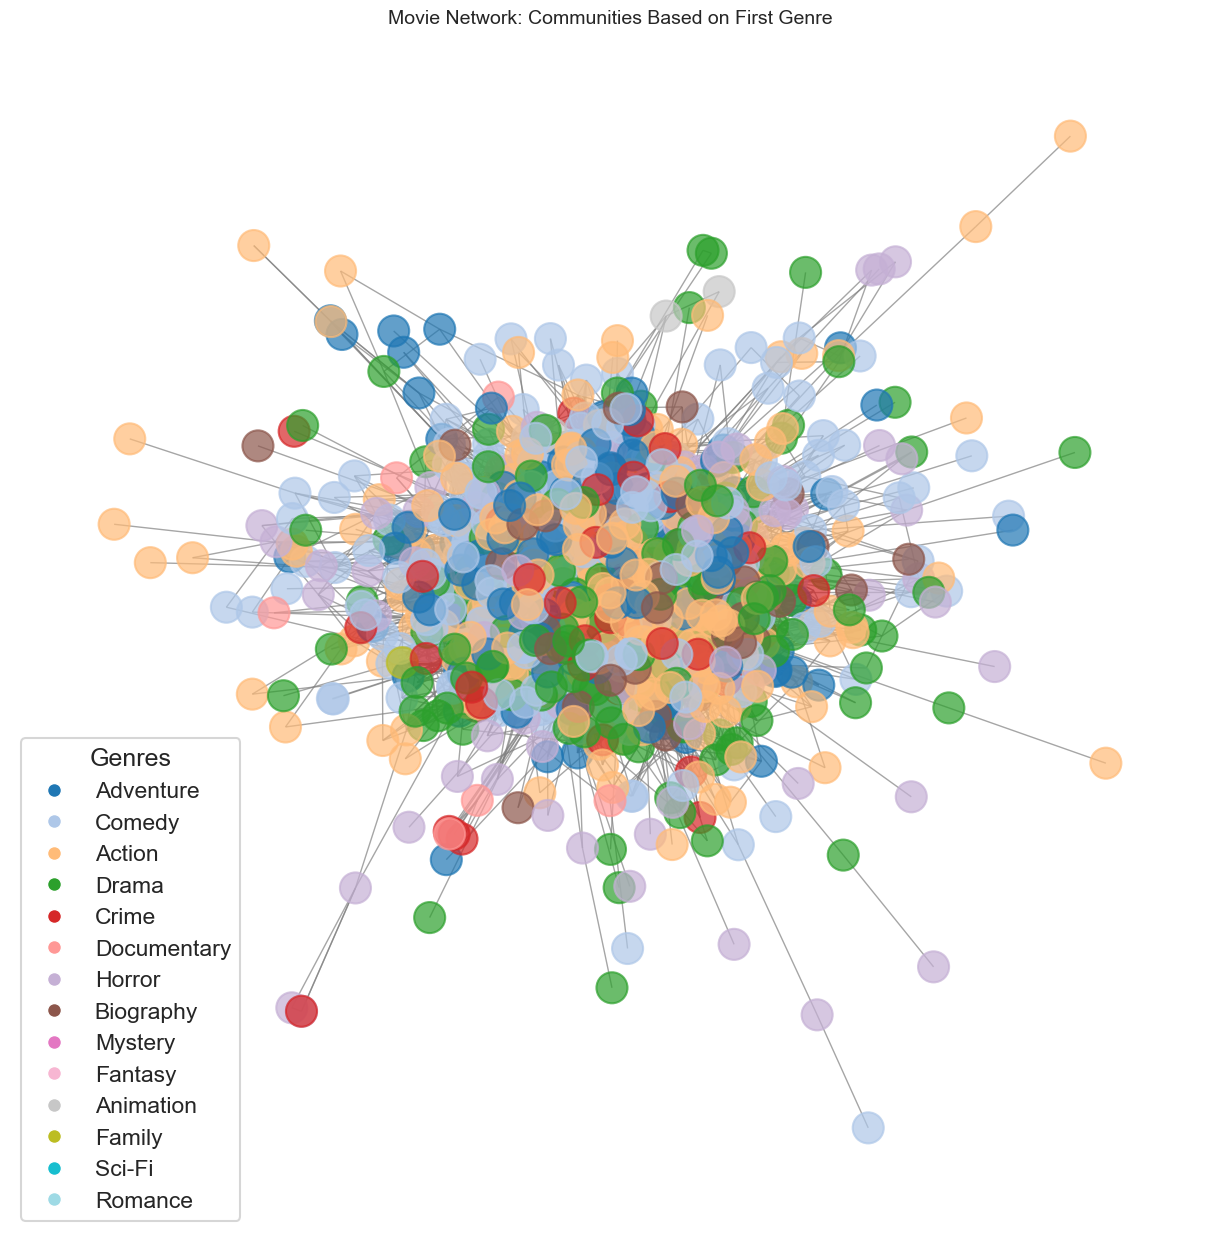

In [629]:
# Generate a color map based on the communities (genres)
color_map = plt.cm.get_cmap("tab20", len(communities_first_genre))

# Create a new plot
plt.figure(figsize=(12, 12))

# Create a list of colors for each node based on its genre community
node_colors = []
for node in graph_largest.nodes():
    # Get the first genre of the movie
    first_genre = graph_largest.nodes(data=True)[node]["genres"][0]
    
    if first_genre != "UNKNOWN":
        # Get the community index for the first genre
        community_idx = list(communities_first_genre.keys()).index(first_genre)
        node_colors.append(color_map(community_idx))
    else:
        node_colors.append((0.5, 0.5, 0.5))  # Default color for UNKNOWN genres

# Draw the network with communities as colors
pos = nx.spring_layout(graph_largest, seed=42)  # Layout for the graph (spring layout is just one option)
nx.draw(graph_largest, pos, node_color=node_colors, with_labels=False, node_size=500, font_size=10, font_weight="bold", edge_color="gray", alpha=0.7)

# Create a list of genres for the legend
genre_labels = list(communities_first_genre.keys())

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), markersize=10) for i in range(len(genre_labels))]
plt.legend(handles, genre_labels, title="Genres", loc='best')
plt.title("Movie Network: Communities Based on First Genre", fontsize=14)
plt.show()

#### Sizes of communities

In [630]:
community_sizes_df = pd.DataFrame(
    [(community, len(nodes)) for community, nodes in communities_first_genre.items()],
    columns=["Community", "Size"]
).sort_values(by="Size", ascending=False)

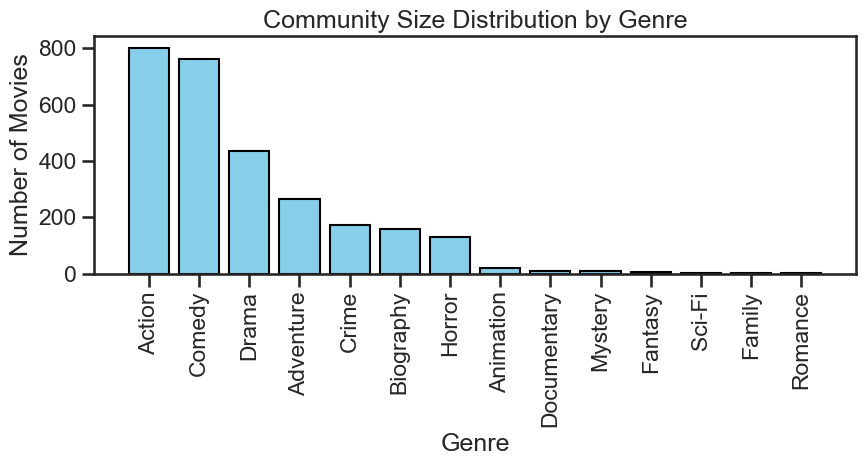

In [631]:
plt.figure(figsize=(9, 5)) 
plt.bar(community_sizes_df["Community"], community_sizes_df["Size"], color="skyblue", edgecolor="black")

# Customize ticks and labels
plt.xticks(rotation=90, ha="center")  # Align x-axis labels vertically
plt.ylabel("Number of Movies")
plt.xlabel("Genre")
plt.title("Community Size Distribution by Genre")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


#### Density of communities

In [632]:
subgraphs = dict_to_subgraphs(communities_first_genre, graph_largest)
densities_df = pd.DataFrame(
    [(list(communities_first_genre.keys())[i], nx.density(subgraph)) 
     for i, subgraph in enumerate(subgraphs)],
    columns=["Community", "Density"]
).sort_values(by="Density", ascending=False)

#### Average degree of communities

In [633]:
avg_degrees = {key: sum([graph_largest.degree(node) for node in nodes]) / len(nodes)
               for key, nodes in communities_first_genre.items()}

#### Clustering coefficient for each community

In [634]:
# Compute clustering coefficient for each community
community_clustering = [
    (
        community,  # Community name
        nx.average_clustering(graph_largest.subgraph(nodes))  # Average clustering coefficient for the subgraph
    )
    for community, nodes in communities_first_genre.items()
]

clustering_df = pd.DataFrame(community_clustering, columns=["Community", "Clustering Coefficient"]).sort_values(
    by="Clustering Coefficient", ascending=False
)

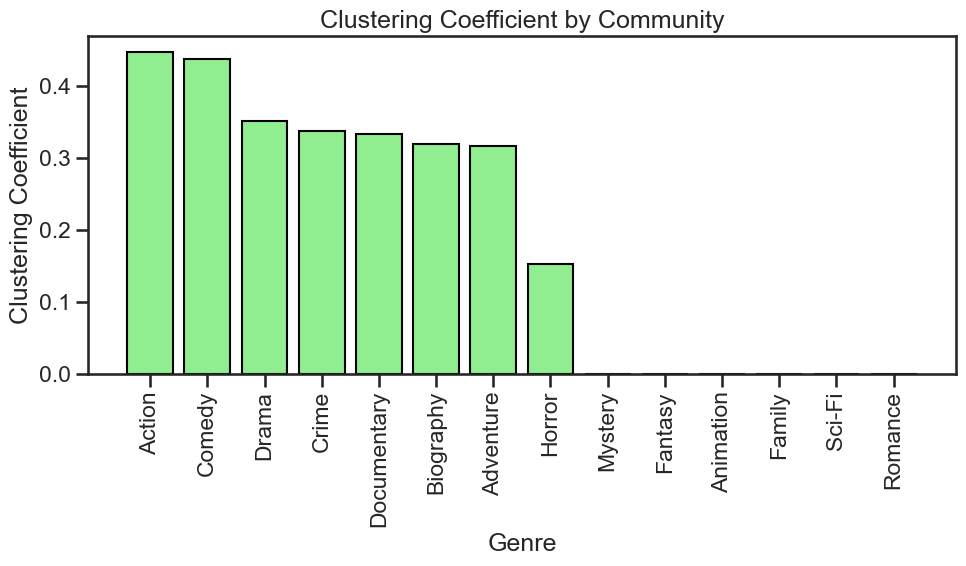

In [635]:
# Bar plot for clustering coefficients
plt.figure(figsize=(10, 6))
plt.bar(clustering_df["Community"], clustering_df["Clustering Coefficient"], color="lightgreen", edgecolor="black")
plt.xticks(rotation=90, ha="center")
plt.ylabel("Clustering Coefficient")
plt.xlabel("Genre")
plt.title("Clustering Coefficient by Community")
plt.tight_layout()
plt.show()

#### SUMMARY TABLE - size, density, avg. degree, avg clustering coefficient


In [636]:
summary_df = pd.DataFrame(
    [
        (
            community,  # Community name
            len(nodes),  # Size (number of nodes in the community)
            nx.density(graph_largest.subgraph(nodes)),  # Density of the subgraph
            sum(graph_largest.degree(node) for node in nodes) / len(nodes),  # Average degree
            nx.average_clustering(graph_largest.subgraph(nodes)) # Average clustering coefficient for the subgraph
        )
        for community, nodes in communities_first_genre.items()
    ],
    columns=["Community", "Size", "Density", "Average Degree", "Avg. Clustering Coefficient"]
).sort_values(by="Size", ascending=False)

#### Inter-Community Edges


In [637]:
# Map each node to its community
node_to_community = {
    node: community
    for community, nodes in communities_first_genre.items()
    for node in nodes
}

# Count inter-community edges
inter_community_edges = sum(
    1 for u, v in graph_largest.edges()
    if node_to_community.get(u) != node_to_community.get(v)
)

# Total edges
total_edges = graph_largest.number_of_edges()

# Proportion of inter-community edges
inter_community_ratio = inter_community_edges / total_edges

print(f"Number of inter-community edges: {inter_community_edges}")
print(f"Proportion of inter-community edges: {inter_community_ratio:.2f}")


Number of inter-community edges: 26870
Proportion of inter-community edges: 0.71


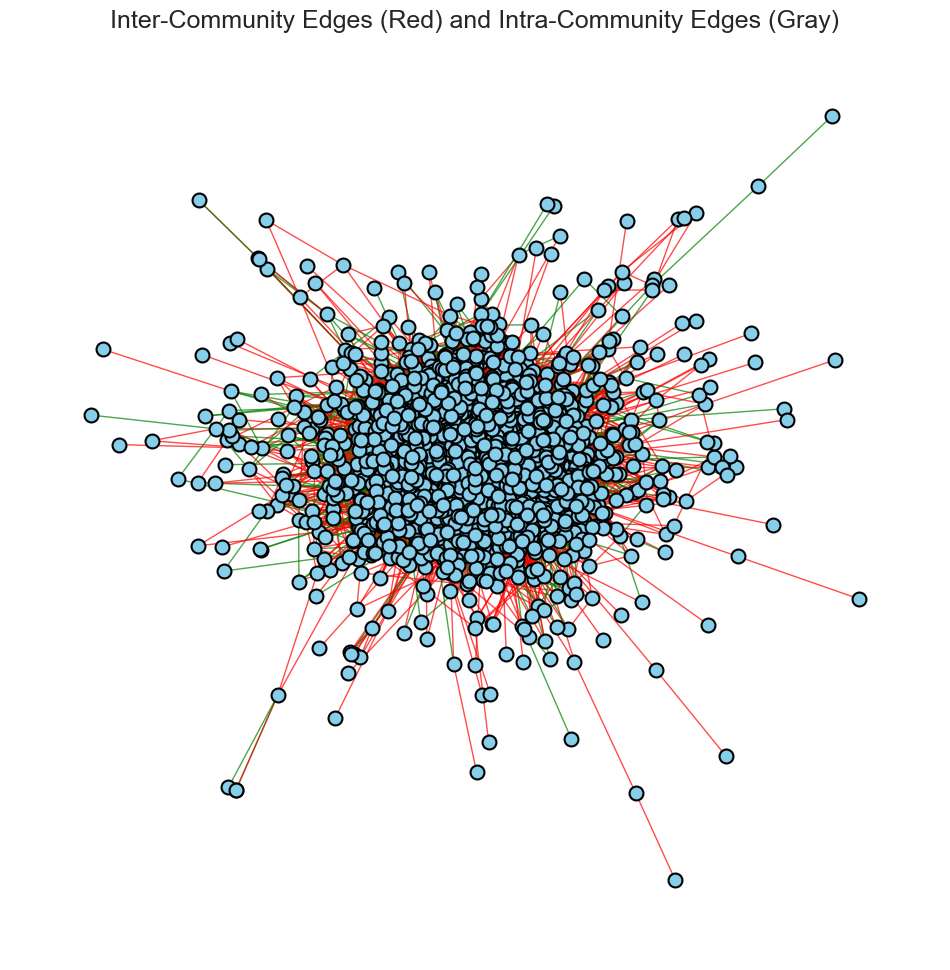

In [638]:
edge_colors = [
    "red" if node_to_community.get(u) != node_to_community.get(v) else "green"
    for u, v in graph_largest.edges()
]

# Draw the graph with edge coloring
pos = nx.spring_layout(graph_largest, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(graph_largest, pos, node_color="skyblue", edgecolors="black", node_size=100)
nx.draw_networkx_edges(graph_largest, pos, edge_color=edge_colors, alpha=0.7)
plt.title("Inter-Community Edges (Red) and Intra-Community Edges (Gray)")
plt.axis("off")
plt.show()


#### Graphs of each genre community

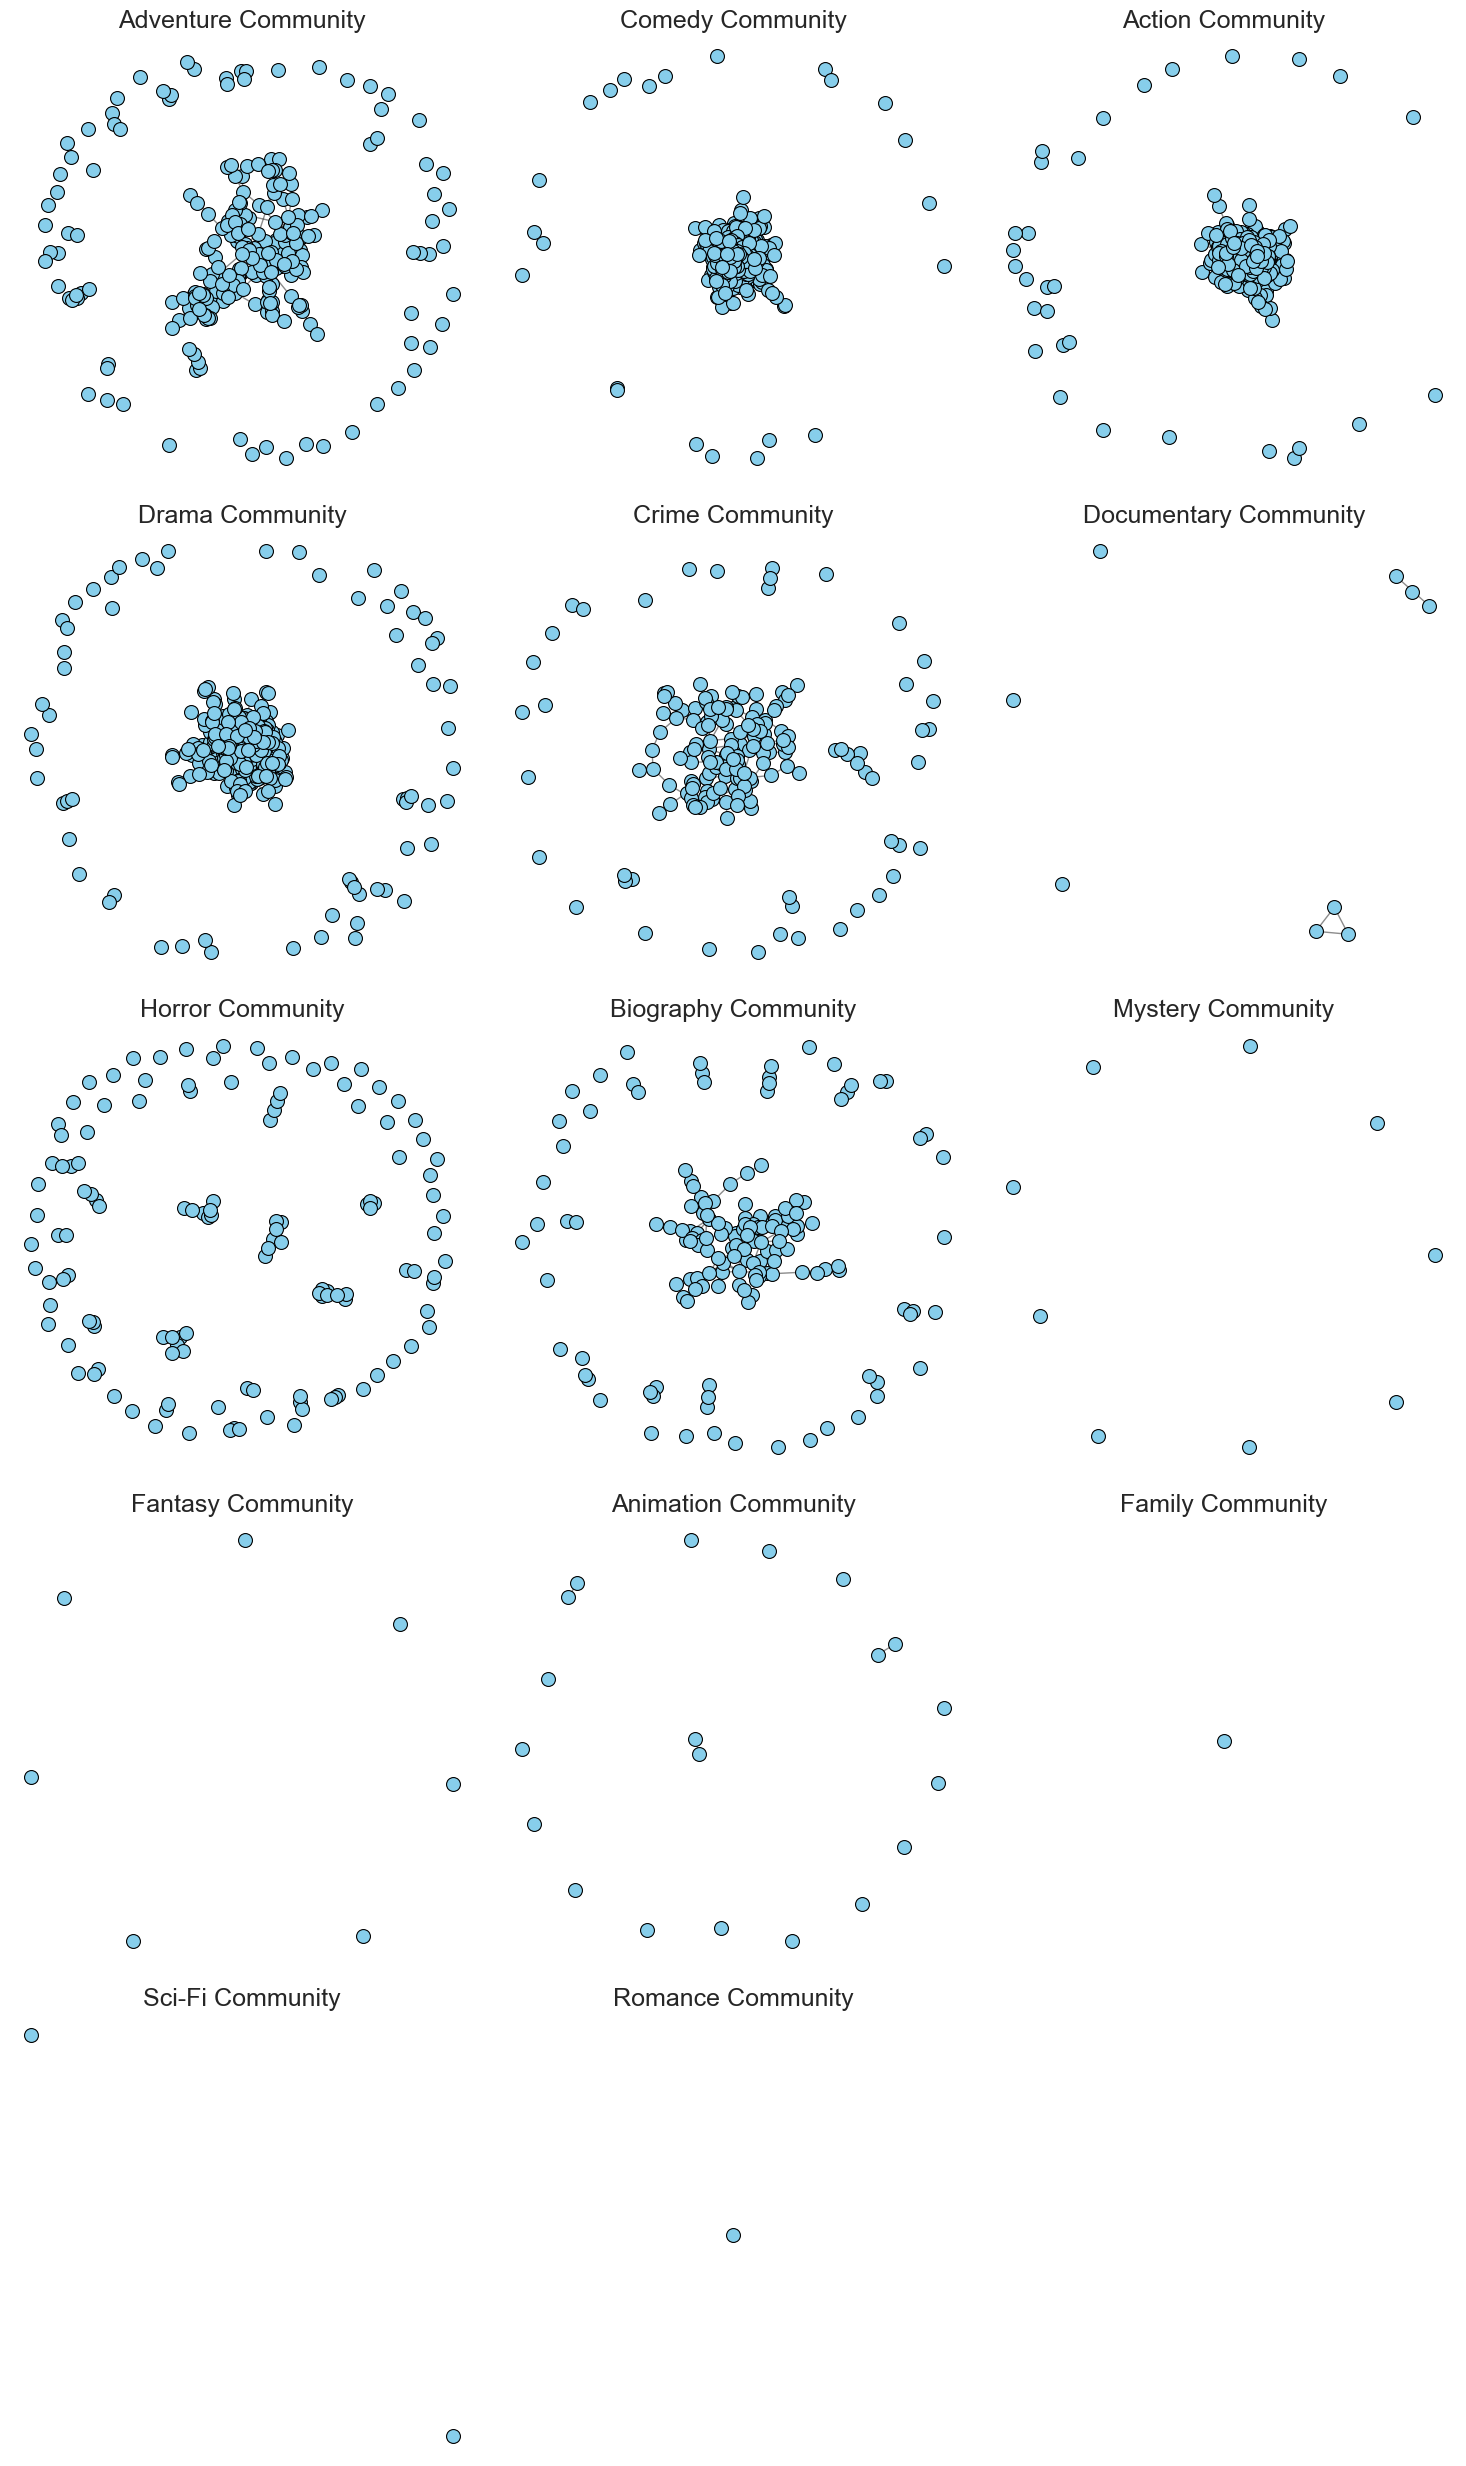

In [639]:
num_communities = len(communities_first_genre)
cols = 3
rows = math.ceil(num_communities / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plot each community in its subplot
for idx, (key, subgraph) in enumerate(zip(communities_first_genre.keys(), subgraphs)):
    ax = axes[idx]
    pos = nx.spring_layout(subgraph, seed=42)

    nx.draw_networkx_nodes(subgraph, pos, 
                           ax=ax,
                           node_color='skyblue', 
                           edgecolors='black', 
                           linewidths=0.8, 
                           node_size=100)
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.5)

    ax.set_title(f"{key} Community")
    ax.axis("off")

for ax in axes[num_communities:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


### Communities by budget
Here we wil split movies based on tiers of budgets and put them in a communities, to see if spending more money on a movie means that you will earn more money.
The tiers are 
- 0 - 1,000,000
- 1,000,000 - 10,000,000
- 10,000,000 - 20,000,000
- 20,000,000 - 30,000,000
- 30,000,000 - 50,000,000
- 50,000,000 - 75,000,000
- 75,000,000 - 100,000,000
- 100,000,000 -200,000,000
- 200,000,000 +

In [640]:
budget_Communities = {
    "0 - 1,000,000": [],
    "1,000,000 - 10,000,000": [],
    "10,000,000 - 20,000,000": [],
    "20,000,000 - 30,000,000": [],
    "30,000,000 - 50,000,000": [],
    "50,000,000 - 75,000,000": [],
    "75,000,000 - 100,000,000": [],
    "100,000,000 - 200,000,000": [],
    "200,000,000 +": []
}

# Assuming graph_largest is your graph
for node in graph_largest.nodes:
    budget = graph_largest.nodes[node]["budget"]
    if budget < 1000000:
        budget_Communities["0 - 1,000,000"].append(node)
    elif budget < 10000000:
        budget_Communities["1,000,000 - 10,000,000"].append(node)
    elif budget < 20000000:
        budget_Communities["10,000,000 - 20,000,000"].append(node)
    elif budget < 30000000:
        budget_Communities["20,000,000 - 30,000,000"].append(node)
    elif budget < 50000000:
        budget_Communities["30,000,000 - 50,000,000"].append(node)
    elif budget < 75000000:
        budget_Communities["50,000,000 - 75,000,000"].append(node)
    elif budget < 100000000:
        budget_Communities["75,000,000 - 100,000,000"].append(node)
    elif budget < 200000000:
        budget_Communities["100,000,000 - 200,000,000"].append(node)
    else:
        budget_Communities["200,000,000 +"].append(node)

budget_Communities_ROI ={
    category: [graph_largest.nodes[movie]["profit"]/graph_largest.nodes[movie]["budget"]
              for movie in movies]
    for category, movies in budget_Communities.items()
}
budget_Communities_sentiment ={
    category: [graph_largest.nodes[movie]["adjusted_sentiment"] 
              for movie in movies]
    for category, movies in budget_Communities.items()
}
budget_Communities_degree ={
    category: [graph_largest.degree(movie)
              for movie in movies]
    for category, movies in budget_Communities.items()
}



for category, values in budget_Communities.items():
    print(f"{category}: {np.mean([graph_largest.nodes[movie]["budget"] for movie in values]):,.3f} -  {len(values)}")


0 - 1,000,000: 383,928.348 -  25
1,000,000 - 10,000,000: 5,912,526.924 -  273
10,000,000 - 20,000,000: 15,103,195.891 -  334
20,000,000 - 30,000,000: 24,652,454.645 -  336
30,000,000 - 50,000,000: 39,632,422.415 -  586
50,000,000 - 75,000,000: 61,232,968.858 -  348
75,000,000 - 100,000,000: 86,605,395.556 -  268
100,000,000 - 200,000,000: 138,573,722.855 -  488
200,000,000 +: 241,425,174.817 -  119


In [641]:
# Calculate the average profit for each budget category
budget_avg_ROI = {category: np.mean(values) 
                         for category, values in budget_Communities_ROI.items()}

budget_avg_sentiment = {category: np.mean(values) 
                         for category, values in budget_Communities_sentiment.items()}

formatted_profits = {k: f"{v:,.2f}" for k, v in budget_avg_ROI.items()}
formatted_sentiments = {k: f"{v:.3f}" for k, v in budget_avg_sentiment.items()}

for key in budget_Communities.keys():
    print(f"Category: {key} - Average ROI in multiplier: {formatted_profits[key]} - Average sentiment: {formatted_sentiments[key]}")
print("-----------------")



# Compute profit variance within communities
budget_variance_profit = {category: np.var(values) 
                             for category, values in budget_Communities_ROI.items()}
budget_variance_sentiment = {category: np.var(values) 
                             for category, values in budget_Communities_sentiment.items()}


formatted_variance_profit = {k: f"{v:.2e}" for k, v in budget_variance_profit.items()}
formatted_variance_sentiment = {k: f"{v:.3f}" for k, v in budget_variance_sentiment.items()}
for key in budget_Communities.keys():
    print(f"Category: {key} - Variance ROI multiplier: {formatted_variance_profit[key]} - Variance sentiment: {formatted_variance_sentiment[key]}")

print("-----------------")
budget_avg_degree = {category: np.mean(values) for category, values in budget_Communities_degree.items()}
budget_variance_degree = {category: np.var(values) for category, values in budget_Communities_degree.items()}

formatted_avg_degree = {k: f"{v:.2f}" for k, v in budget_avg_degree.items()}
formatted_variance_degree = {k: f"{v:.2f}" for k, v in budget_variance_degree.items()}
for key in budget_Communities.keys():
    print(f"Category: {key} - Average degree: {formatted_avg_degree[key]} - Variance degree: {formatted_variance_degree[key]}")



Category: 0 - 1,000,000 - Average ROI in multiplier: 119.62 - Average sentiment: 0.217
Category: 1,000,000 - 10,000,000 - Average ROI in multiplier: 4.54 - Average sentiment: 0.171
Category: 10,000,000 - 20,000,000 - Average ROI in multiplier: 2.03 - Average sentiment: 0.177
Category: 20,000,000 - 30,000,000 - Average ROI in multiplier: 1.36 - Average sentiment: 0.165
Category: 30,000,000 - 50,000,000 - Average ROI in multiplier: 1.13 - Average sentiment: 0.187
Category: 50,000,000 - 75,000,000 - Average ROI in multiplier: 0.96 - Average sentiment: 0.173
Category: 75,000,000 - 100,000,000 - Average ROI in multiplier: 0.93 - Average sentiment: 0.173
Category: 100,000,000 - 200,000,000 - Average ROI in multiplier: 1.00 - Average sentiment: 0.201
Category: 200,000,000 + - Average ROI in multiplier: 1.55 - Average sentiment: 0.222
-----------------
Category: 0 - 1,000,000 - Variance ROI multiplier: 2.48e+05 - Variance sentiment: 0.019
Category: 1,000,000 - 10,000,000 - Variance ROI multipl

We see that The sentiment on average increase as the budget increase. Moreover, the return on investment decreases as the budget increases. However, lower budget movies seems to have higher variance meaning that the ROI could be so much more, for example "The Blair Witch Project" move only had 60,000 budget but had 60,000 USD budget but it grossed more than 240 million USD. Furthermore, the sentiment seems to stabiles at higher budgets.  

Finally, The degree of each movie indicate the popularity of the actors playing in the movie. For lower budget the average degree is $\approx$ 7 and this increases as the budget increase. Which makes sense since having bigger budget means you are able to higher bigger actors  

In [642]:
subgraphs = dict_to_subgraphs(budget_Communities, graph_largest)
print(f"Modularity: {modularity(subgraphs, graph_largest):.3f}")

Modularity: 0.023


### Louvain Communities

#### Modularity


In [643]:
## louvain algorithm to partition the graph into communities
partition = community_louvain.best_partition(graph)
value_to_keys = {} #Fliping the keys and values
for key, value in partition.items():
    if value not in value_to_keys:
        value_to_keys[value] = []
    value_to_keys[value].append(key)

print("Modularity based on louvain", modularity(dict_to_subgraphs(value_to_keys,graph),graph))

Modularity based on louvain 0.4479785177073203


#### Average actor popularity, profit and sentiment within communities

In [644]:
communities = dict_to_subgraphs(value_to_keys,graph)
average_popularities = []
average_sentiments = []
average_profits = []

# Keep communities with more than 10 nodes for statistically significant results
min_number_of_community_nodes = 50
sub_communities = [c for c in communities if c.number_of_nodes() >= min_number_of_community_nodes]
for community in sub_communities:

    number_of_movies = community.number_of_nodes()
    
    # Average popularity
    community_total_actor_popularities = nx.get_node_attributes(community, "total_actor_popularity")
    average_community_actor_popularity = sum(community_total_actor_popularities.values()) / number_of_movies
    average_popularities.append(average_community_actor_popularity)
    
    # Average sentiment
    community_sentiments = nx.get_node_attributes(community, "adjusted_sentiment")
    mean_sentiment = sum(community_sentiments.values()) / number_of_movies
    average_sentiments.append(mean_sentiment)
    
    # Average profit
    community_profits = nx.get_node_attributes(community, "profit")
    mean_profit = sum(community_profits.values()) / number_of_movies
    average_profits.append(mean_profit)

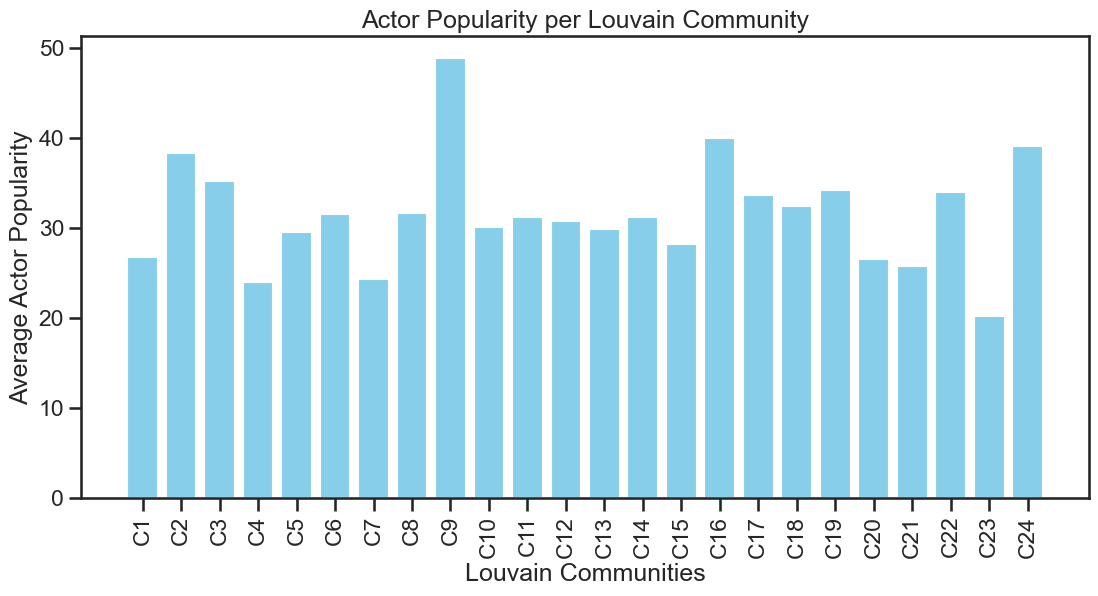

In [645]:
# Example data
data = {
    'Community': [f"C{i+1}" for i in range(len(sub_communities))],
    'Popularity': average_popularities,
    'Sentiment': average_sentiments,
    'Profit': average_profits
}

# Convert data to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Popularity'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Actor Popularity')
plt.title('Actor Popularity per Louvain Community')
plt.show()

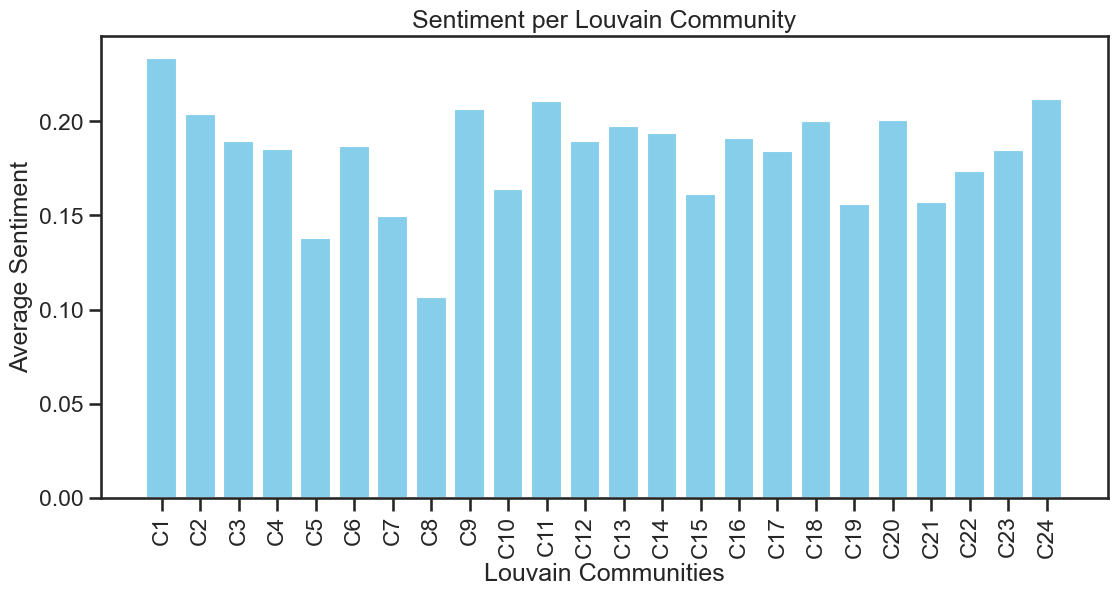

In [646]:
# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Sentiment'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Sentiment')
plt.title('Sentiment per Louvain Community')
plt.show()

Text(0.5, 1.0, 'Profit per Louvain Community')

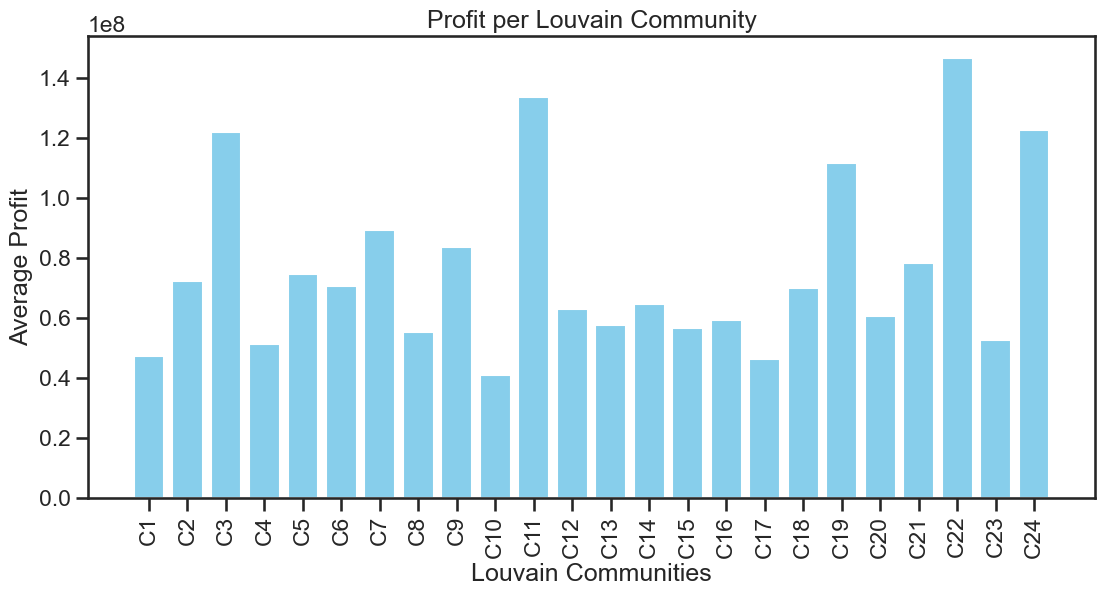

In [647]:
# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Profit'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Profit')
plt.title('Profit per Louvain Community')

#### Inter-community relationships

In [648]:
# List of inter-community edges
inter_community_edges = [
    (u, v) for u, v in graph.edges()
    if partition[u] != partition[v]
]

# Find bridge nodes (nodes that have edges with other communities than the one they belong to
bridge_nodes = set([node for edge in inter_community_edges for node in edge])
community_connections = defaultdict(set)
for u, v in inter_community_edges:
    community_connections[u].add(partition[v])
    community_connections[v].add(partition[u])

inter_community_degree = {node: len(communities) for node, communities in community_connections.items()}
top__inter_community_nodes = sorted(inter_community_degree.items(), key=lambda item: item[1], reverse=True)[:10]

print("Top 10 Bridge Nodes:", top__inter_community_nodes)

Top 10 Bridge Nodes: [('Runaway Jury', 20), ('Twilight', 20), ('Stepmom', 20), ('The Contender', 20), ('The Cider House Rules', 20), ('Shall We Dance', 19), ('White Oleander', 19), ('The Italian Job', 19), ('Cyrus', 19), ('Closer', 19)]


#### Sentiment Analysis in Louvain communities

In [649]:
# Group by Community and compute the variance of sentiment for communities
df.var(ddof=0, numeric_only=True).loc["Sentiment"]

np.float64(0.0007266877912548006)

The low variance that we observe indicates consistent audience sentiment between communities.

Our next goal is to identify whether highly connected communities (which in our case means that are communities with more popular actors) show higher sentiment.

In [650]:
# Compute internal density for each community

def calculate_inter_community_density(communities):
    
    internal_densities = []
    
    for c in communities:
        num_nodes = c.number_of_nodes()
        num_edges = c.number_of_edges()
    
        internal_density = (2 * num_edges) / (num_nodes * (num_nodes - 1))
        
        internal_densities.append(internal_density)
        
    return internal_densities

densities = calculate_inter_community_density(sub_communities)
df['Density'] = densities

In [651]:
# Test if there is statistically significant correlation between the internal density of a community and its average sentiment

# Calculate the Pearson correlation coefficient and p-value
corr, p_value = stats.pearsonr(df['Density'], df['Profit'])

# Print results
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")

# Check if p-value is less than significance level (e.g., 0.05)
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

spearman_corr, spearman_p = stats.spearmanr(df['Density'], df['Profit'])
# Print results
print(f"\n\nSpearman correlation coefficient: {spearman_corr}")
print(f"P-value: {spearman_p}")

# Check if p-value is less than significance level (e.g., 0.05)
if spearman_p < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson correlation coefficient: 0.1260931628648444
P-value: 0.5571348439347201
The correlation is not statistically significant.


Spearman correlation coefficient: 0.06869565217391303
P-value: 0.749764493394595
The correlation is not statistically significant.


#### Plot correlation of actor popularity, earnings and sentiment within communities

<Figure size 1500x1000 with 0 Axes>

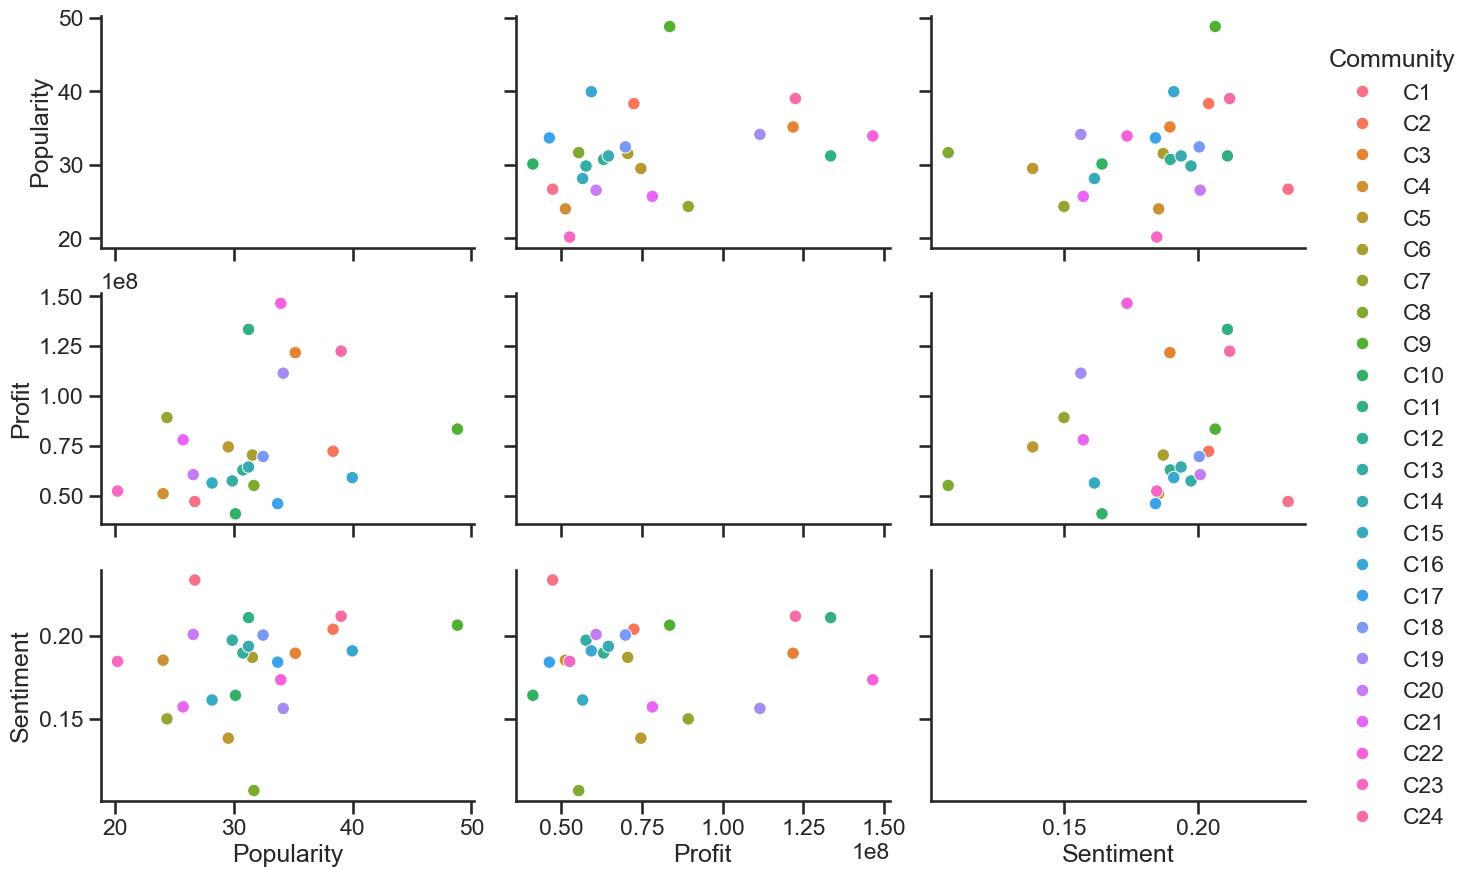

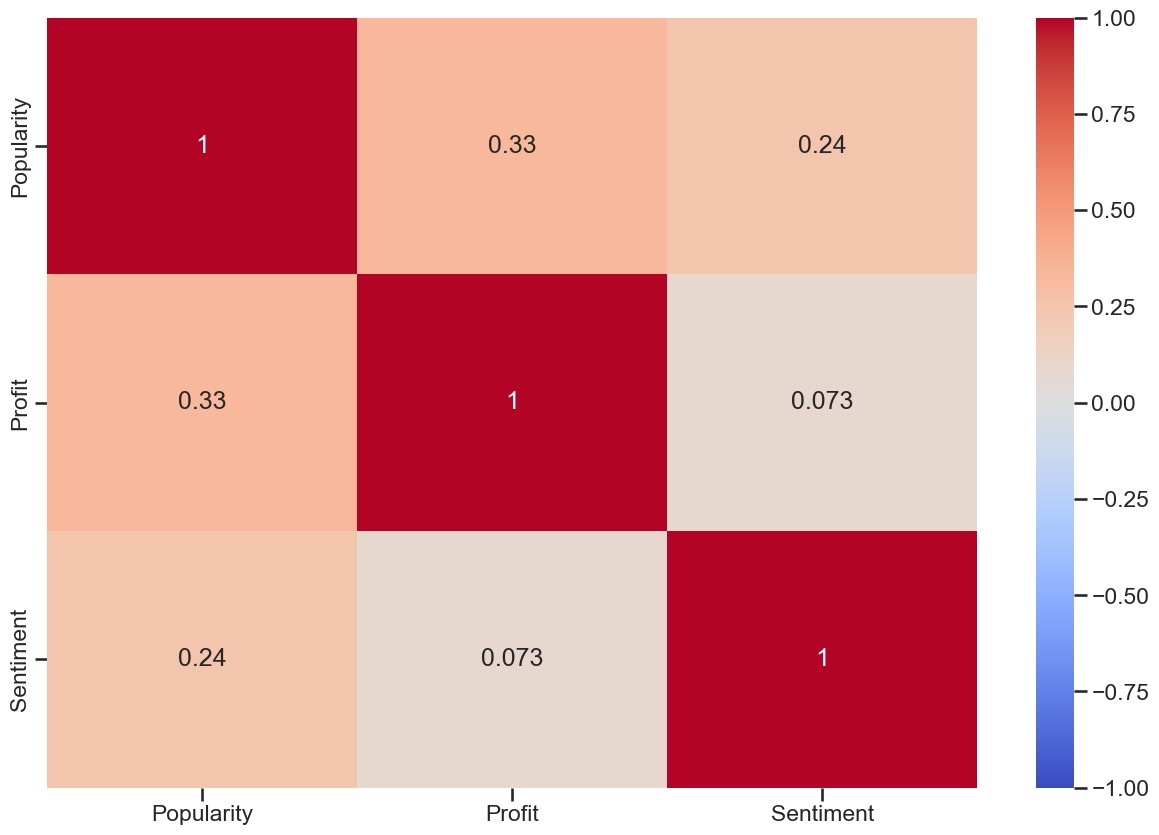

In [652]:
# Plot Pairplot
fig = plt.figure(figsize=(15, 10))
sns.pairplot(df[['Community', 'Popularity', 'Profit', 'Sentiment']], kind='scatter', hue='Community', markers='o', height=3, aspect=1.5)
plt.savefig("communities_scatter_plot.png", dpi=600, bbox_inches='tight')
plt.show()

# Correlation matrix heatmap with same size as pairplot
plt.figure(figsize=(15, 10))  # Same width and height as pairplot
corr_matrix = df[['Popularity', 'Profit', 'Sentiment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.savefig("communities_heatmap.png", dpi=600, bbox_inches='tight')
plt.show()

In [653]:
def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
                
set_node_community(graph, communities)
set_edge_community(graph)

#### Plot top-6 Louvain communities

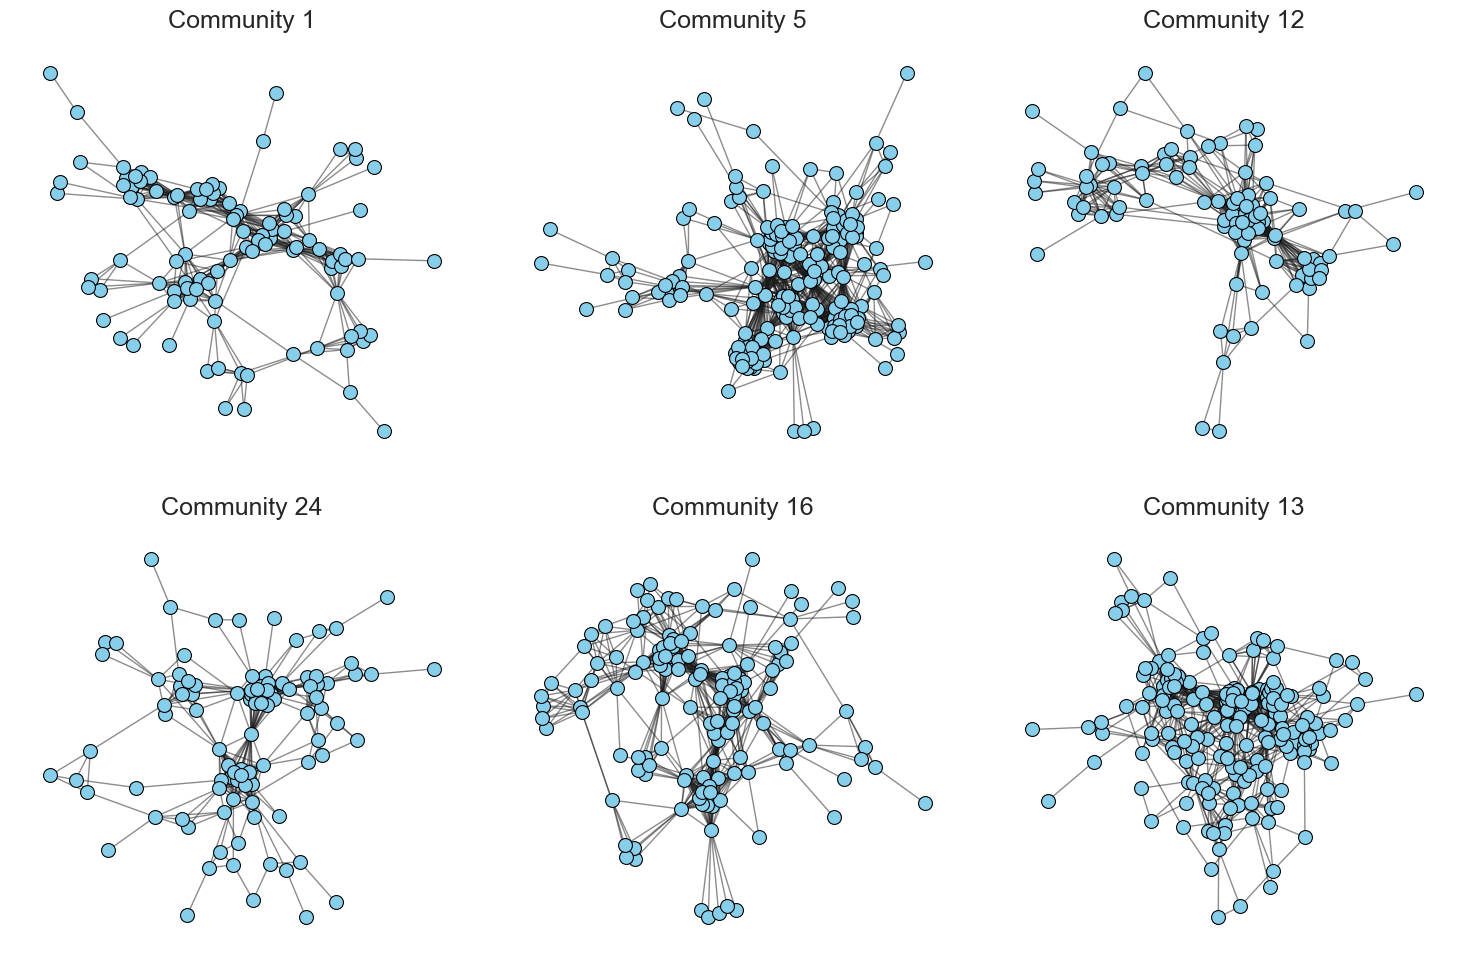

In [654]:
# Plot preprocessing
num_communities = 6
cols = 3
rows = math.ceil(num_communities / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Sort dictionary and get top 6 communities
sorted_items = sorted(value_to_keys.items(), key=lambda item: len(item[1]), reverse=True)
top_communities = dict(sorted_items[:num_communities])

# Plot each community in its subplot
for idx, (key, subgraph) in enumerate(zip(top_communities.keys(), communities)):
    ax = axes[idx]
    pos = nx.spring_layout(subgraph, seed=42)

    nx.draw_networkx_nodes(subgraph, pos, 
                           ax=ax,
                           node_color='skyblue', 
                           edgecolors='black', 
                           linewidths=0.8, 
                           node_size=100)
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.5)

    ax.set_title(f"Community {key}")
    ax.axis("off")

for ax in axes[num_communities:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.savefig("louvain_top_communities.png", dpi=400, bbox_inches='tight')
plt.show()

In [655]:
# Top communities subgraph
num_communities = 8

# Sort dictionary and get top communities
sorted_items = sorted(value_to_keys.items(), key=lambda item: len(item[1]), reverse=True)
top_communities = dict(sorted_items[:num_communities])

# Create a subgraph with nodes from the top 8 communities
top_nodes = []
for comm in top_communities:
    top_nodes.extend(top_communities[comm])

top_communities_graph = graph.subgraph(top_nodes)


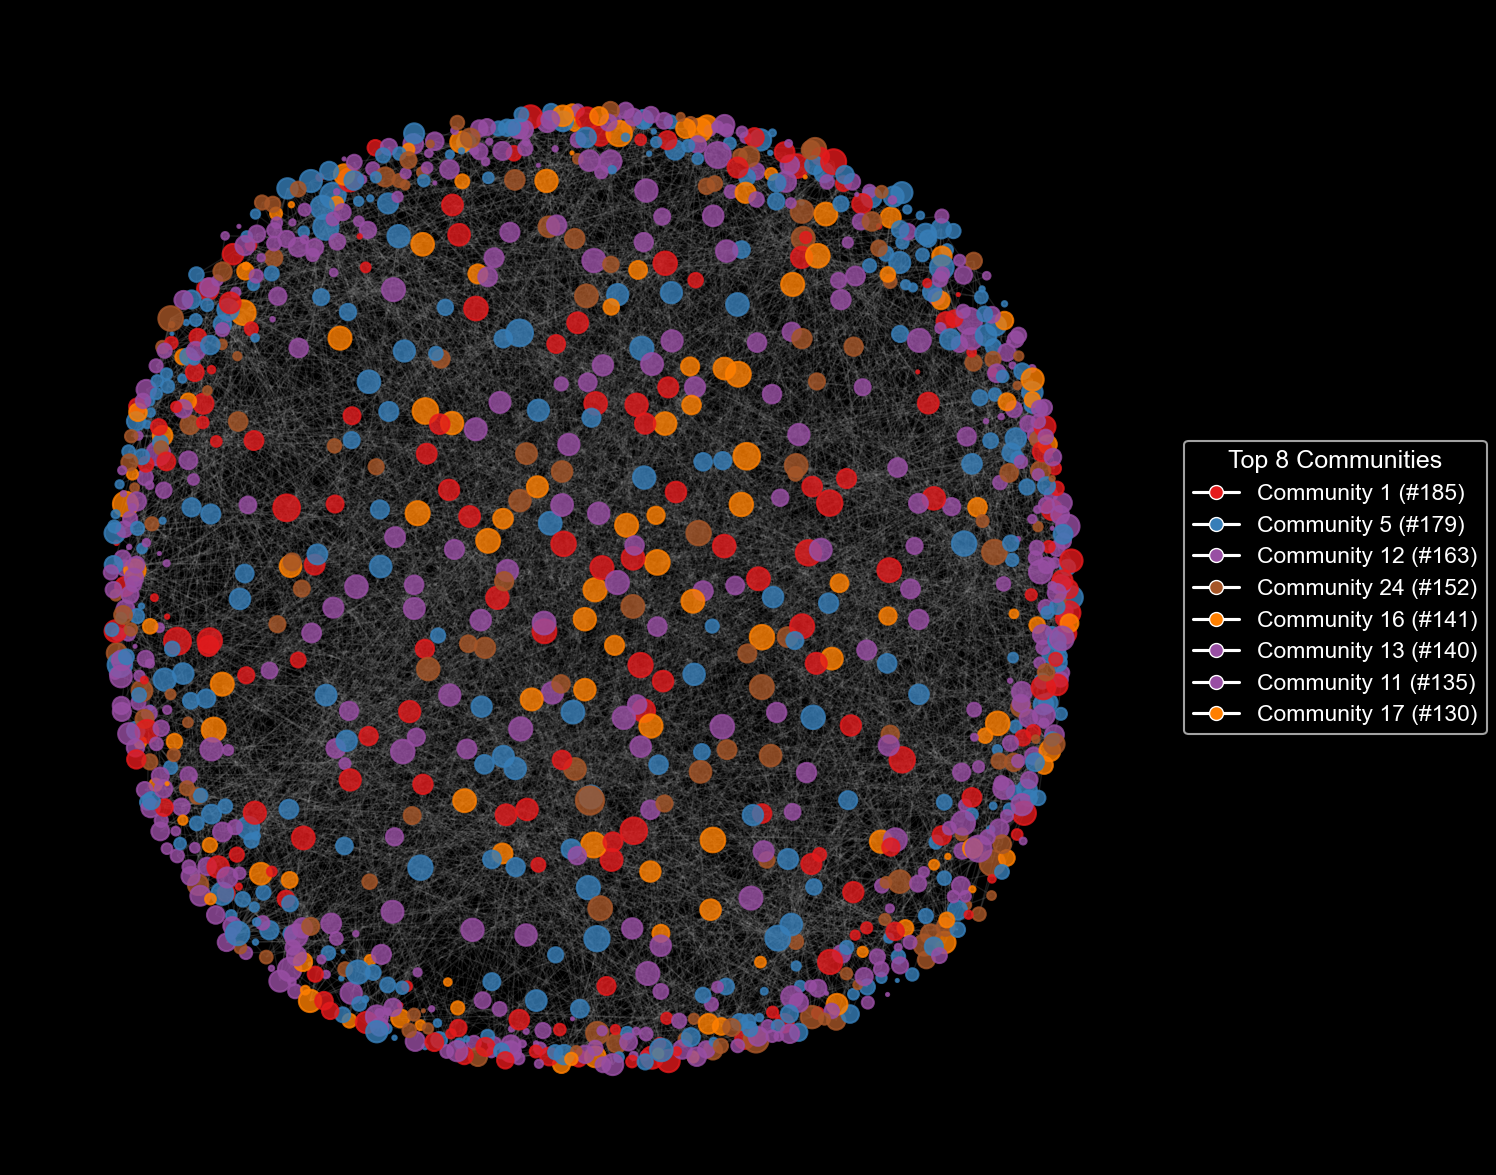

In [656]:
# Adjust layout
pos = nx.spring_layout(top_communities_graph, k=1.2, scale=10)  # Increase scale to zoom in
plt.rcParams.update({'figure.figsize': (15, 15)})
plt.style.use('dark_background')

# External and internal edges
external = [(v, w) for v, w in top_communities_graph.edges if top_communities_graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in top_communities_graph.edges if top_communities_graph.edges[v, w]['community'] > 0]
internal_color = ["black" for e in internal]

# Node colors
cmap = plt.get_cmap('Set1')  # You can change 'viridis' to any other colormap
norm = plt.Normalize(vmin=0, vmax=len(communities) - 1)
node_color = [cmap(norm(top_communities_graph.nodes[v]['community'])) for v in top_communities_graph.nodes]

# Calculate node size based on degree (larger degree = larger node)
degrees = {node: graph.degree(node) for node in graph}
node_size = [degrees[node] * 5 for node in top_communities_graph.nodes]  # Adjust the multiplier as needed

# Draw edges (background)
nx.draw_networkx_edges(
    top_communities_graph,
    pos=pos,
    edgelist=external,
    edge_color="silver",
    alpha=0.15
)
nx.draw_networkx_edges(
    top_communities_graph, 
    pos=pos,
    edgelist=internal,
    edge_color=internal_color,
    alpha=0.05
)

# Draw nodes (foreground)
nx.draw_networkx_nodes(
    top_communities_graph,
    pos=pos,
    node_size=node_size,  # Increase node size for better visibility
    node_color=node_color,
    alpha=0.8,  # Make nodes more visible
)

# Add legend for community colors
handles = []
labels = []
for comm, nodes in top_communities.items():
    # Create a custom label for each community with its color
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(comm)), markersize=10))
    labels.append(f"Community {comm} (#{len(nodes)})")

plt.legend(handles=handles, labels=labels, title=f"Top {num_communities} Communities", loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis("off")# Hide axes
plt.savefig("louvain_top_communities.png", dpi=400, bbox_inches='tight')
plt.show()
